In [31]:
# Basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from datetime import datetime
# Sklearn components
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
# Advanced ML models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
# Explainability tools
import shap
from lime import lime_tabular
# Utilities
import joblib
import warnings
warnings.filterwarnings("ignore")
import optuna
# Visualization settings
plt.style.use('seaborn-whitegrid')
sns.set_palette("deep")

Dataset shape: (119390, 32)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119

<Figure size 1200x600 with 0 Axes>

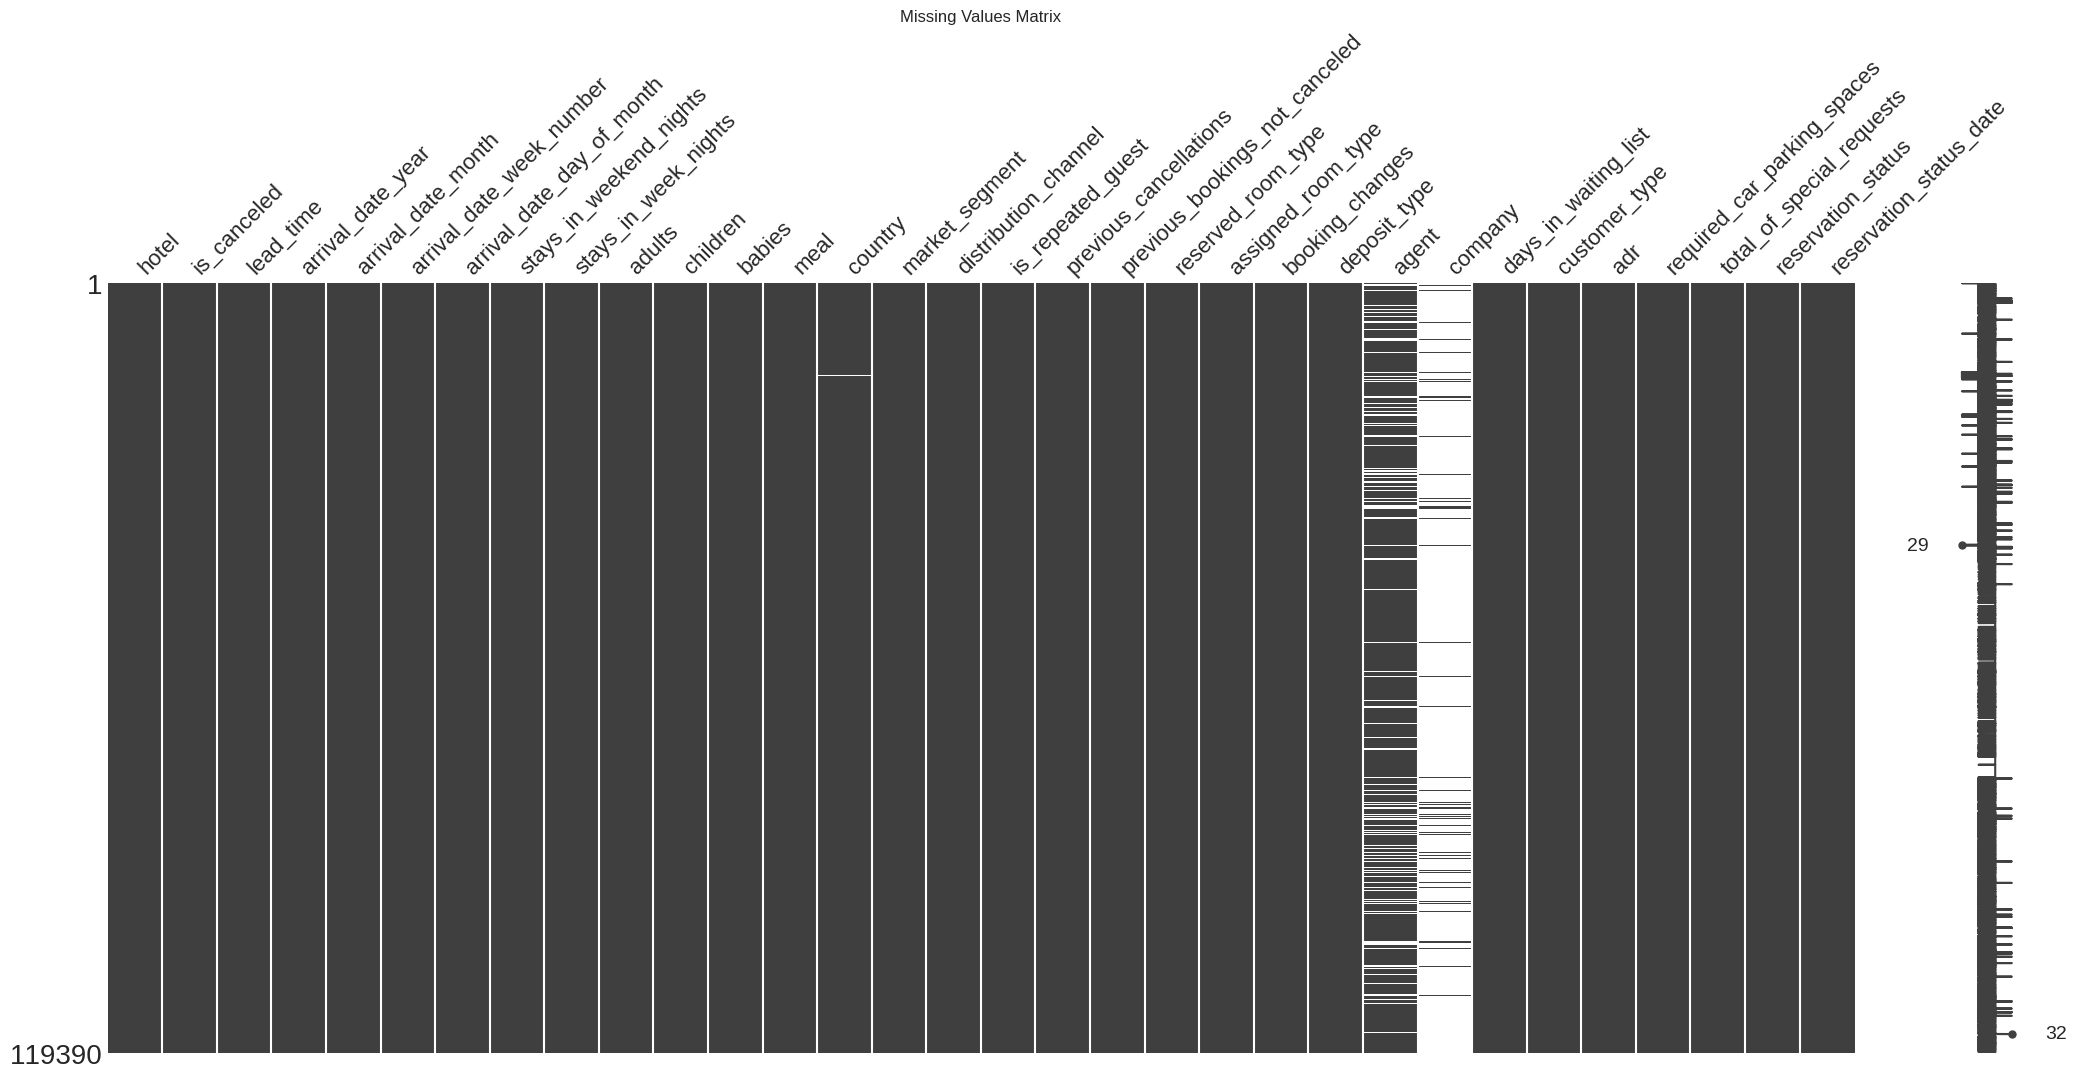

In [32]:
# section 2: Load & Explore Dataset
# Load dataset
file_path = "/kaggle/input/hotelbooking/HotelBooking.csv"
df = pd.read_csv(file_path)

# Display basic info
print(f"Dataset shape: {df.shape}")
print("\nDataset info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

# Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Visualize missing values
plt.figure(figsize=(12, 6))
msno.matrix(df)
plt.title("Missing Values Matrix")
plt.show()

In [33]:
# section 3: Data Preprocessing

# Make a copy of the original data
df_original = df.copy()

# Function to handle missing values more intelligently
def handle_missing_values(df):
    df_clean = df.copy()
    
    # Handle missing values based on the type of column
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            if df[column].dtype == 'object':
                # For categorical columns, use most frequent value
                df_clean[column].fillna(df[column].mode()[0], inplace=True)
            else:
                # For numerical columns, use median
                df_clean[column].fillna(df[column].median(), inplace=True)
    
    return df_clean

df = handle_missing_values(df)

# Make column names consistent
df.columns = df.columns.str.lower()

# Convert object types to lowercase strings
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.lower()

# Convert 'is_canceled' to binary target variable
df['is_canceled'] = df['is_canceled'].astype(int)

# Identify column types for proper preprocessing
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('is_canceled')  # Remove target from features

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")


Numeric features: 19
Categorical features: 12


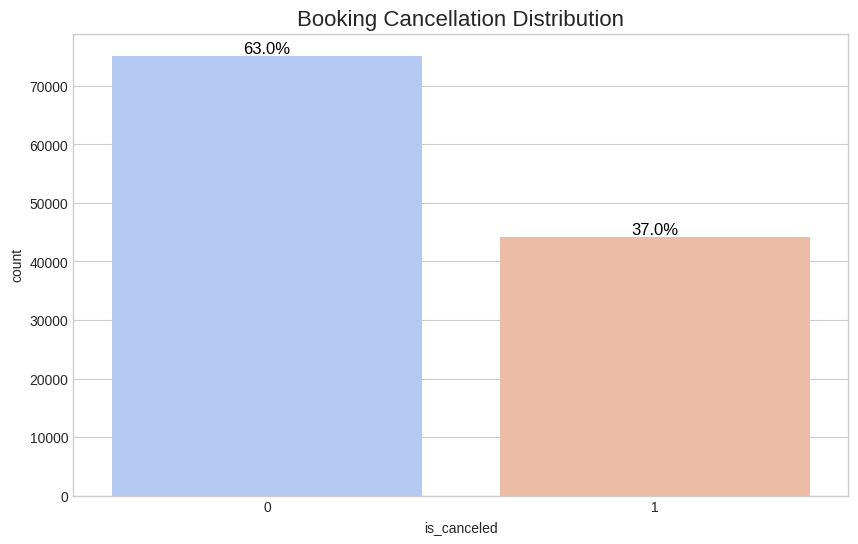

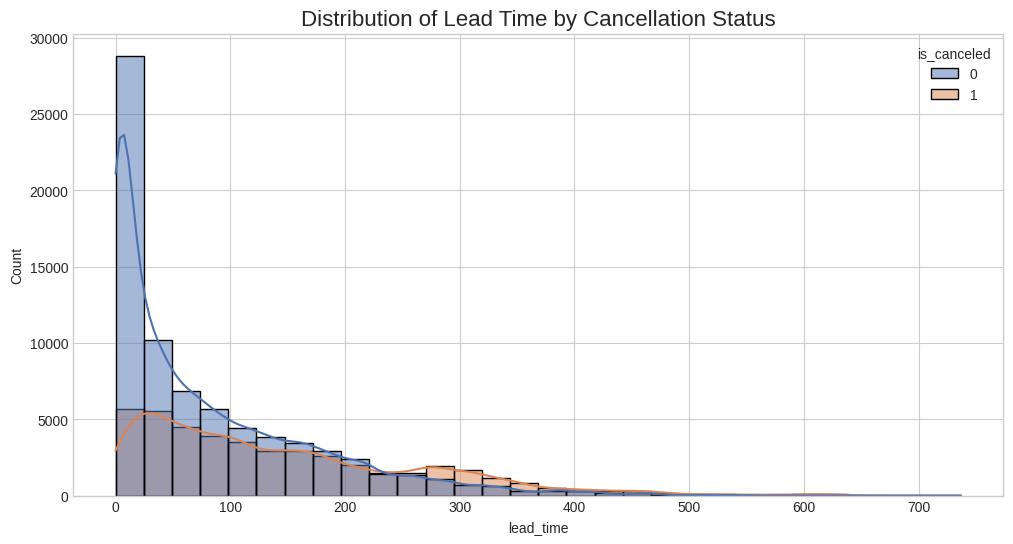

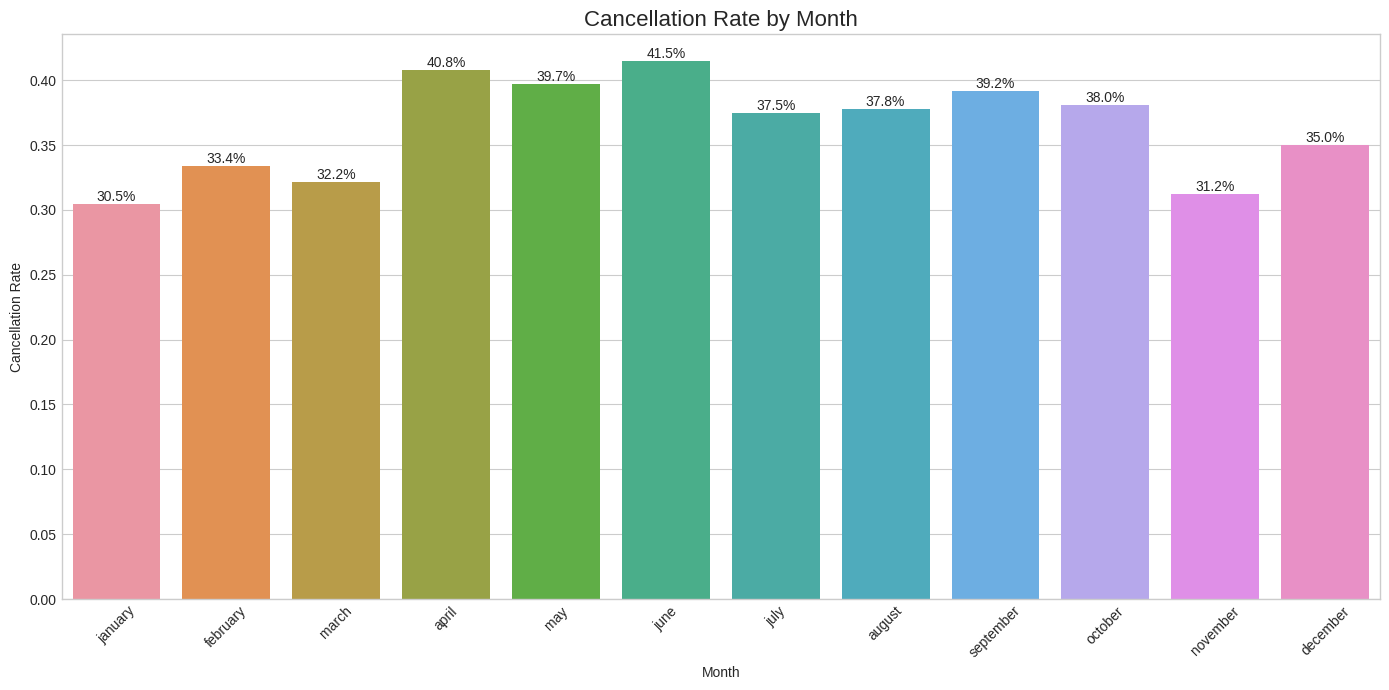

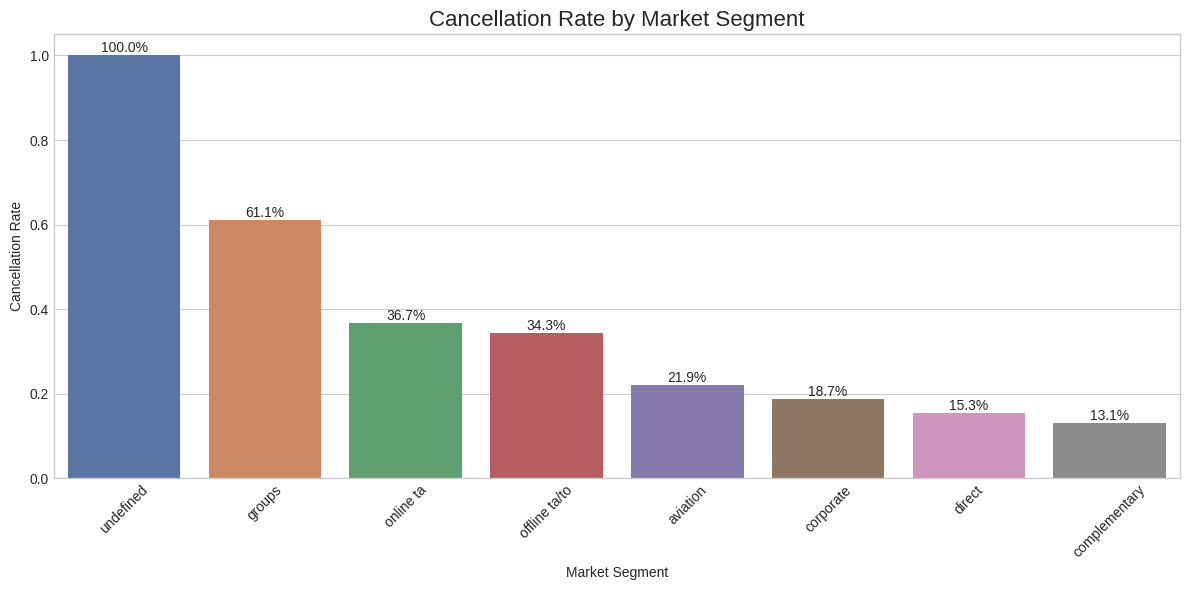

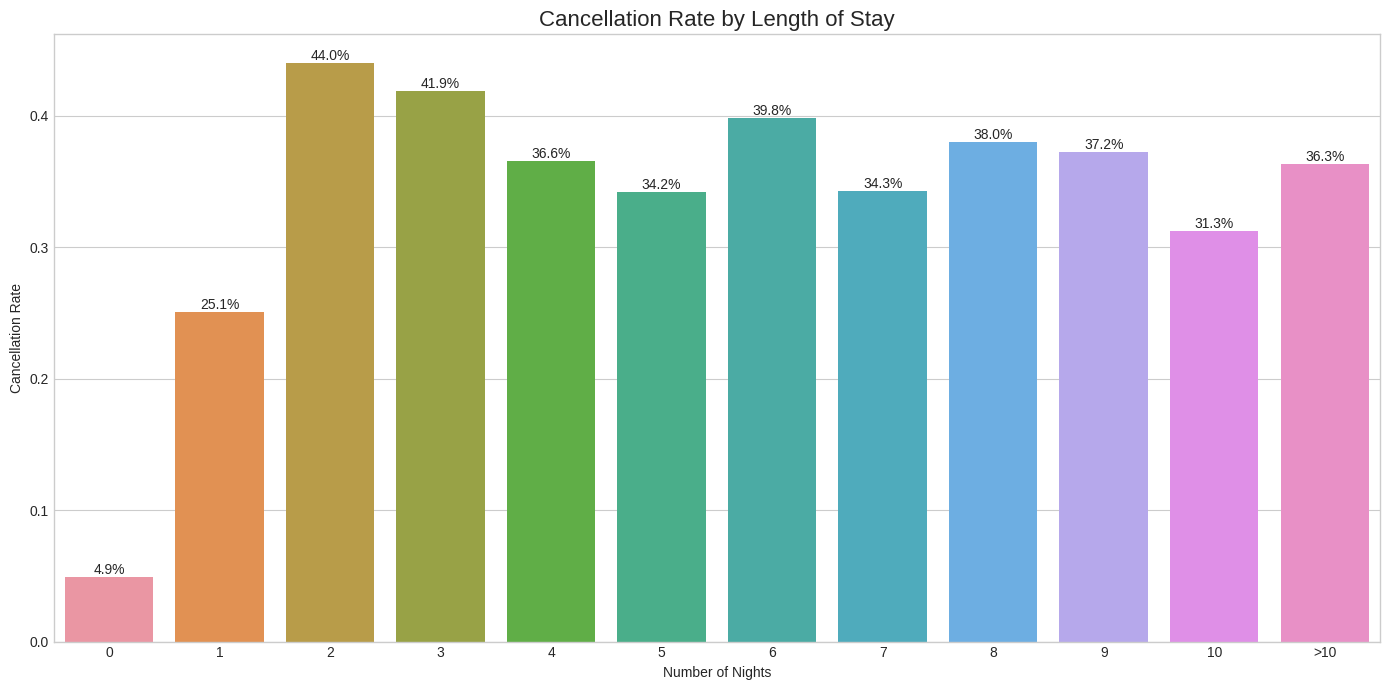

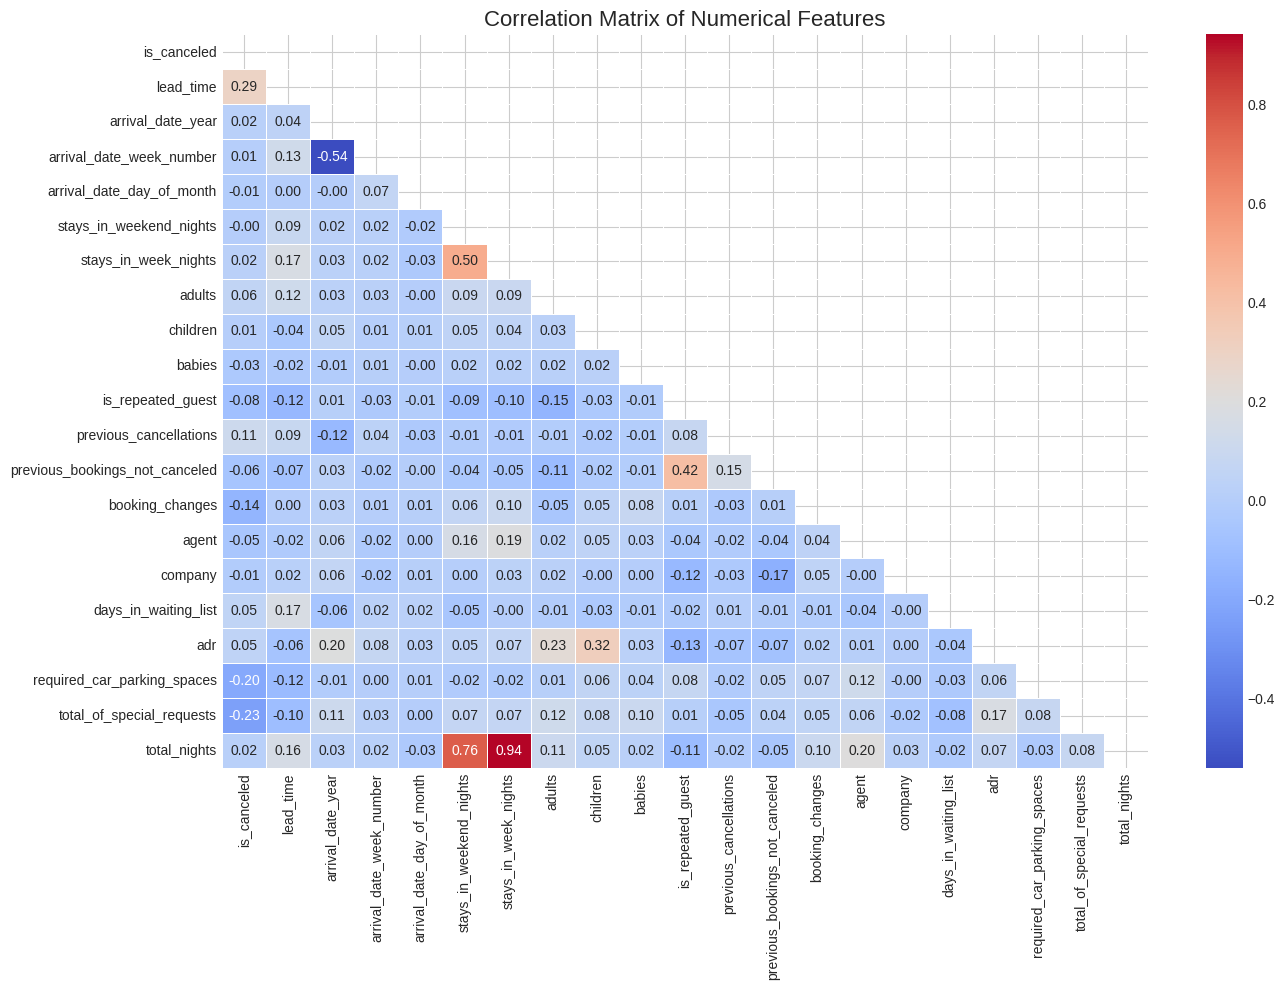

In [34]:
# Section 4: Exploratory Data Analysis (EDA)
# ===================================================
# Plot distribution of target variable
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='is_canceled', data=df, palette="coolwarm")
plt.title("Booking Cancellation Distribution", fontsize=16)
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

# Distribution of lead time by cancellation status
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='lead_time', hue='is_canceled', bins=30, kde=True)
plt.title('Distribution of Lead Time by Cancellation Status', fontsize=16)
plt.show()

# Analyze booking patterns by season or month
if 'arrival_date_month' in df.columns:
    plt.figure(figsize=(14, 7))
    # Convert month names to datetime for proper ordering
    month_order = ["January", "February", "March", "April", "May", "June", 
                  "July", "August", "September", "October", "November", "December"]
    month_order = [m.lower() for m in month_order]
    
    cancellation_rates = df.groupby('arrival_date_month')['is_canceled'].mean().reindex(
        month_order).reset_index()
    
    ax = sns.barplot(x='arrival_date_month', y='is_canceled', data=cancellation_rates)
    plt.title('Cancellation Rate by Month', fontsize=16)
    plt.xlabel('Month')
    plt.ylabel('Cancellation Rate')
    plt.xticks(rotation=45)
    
    # Add percentage labels on bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1%}", (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

# Market segment analysis
if 'market_segment' in df.columns:
    plt.figure(figsize=(12, 6))
    segment_counts = df.groupby(['market_segment', 'is_canceled']).size().unstack()
    segment_counts['total'] = segment_counts.sum(axis=1)
    segment_counts['cancel_rate'] = segment_counts[1] / segment_counts['total']
    segment_counts = segment_counts.sort_values('cancel_rate', ascending=False)
    
    ax = sns.barplot(x=segment_counts.index, y=segment_counts['cancel_rate'])
    plt.title('Cancellation Rate by Market Segment', fontsize=16)
    plt.xlabel('Market Segment')
    plt.ylabel('Cancellation Rate')
    plt.xticks(rotation=45)
    
    # Add percentage labels
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1%}", (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

# Analyze cancellation by total stay duration
if 'stays_in_weekend_nights' in df.columns and 'stays_in_week_nights' in df.columns:
    df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
    plt.figure(figsize=(14, 7))
    
    # Group total_nights above 10 to avoid sparse data
    df['total_nights_grouped'] = df['total_nights'].apply(lambda x: x if x <= 10 else '>10')
    
    # Calculate cancellation rate by stay duration
    cancellation_by_duration = df.groupby('total_nights_grouped')['is_canceled'].mean().reset_index()
    
    ax = sns.barplot(x='total_nights_grouped', y='is_canceled', data=cancellation_by_duration)
    plt.title('Cancellation Rate by Length of Stay', fontsize=16)
    plt.xlabel('Number of Nights')
    plt.ylabel('Cancellation Rate')
    
    # Add percentage labels
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1%}", (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(14, 10))
correlation = df.select_dtypes(include=['int64', 'float64']).corr()
mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlation, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

In [35]:
# SECTION 5: Advanced Feature Engineering
# ===================================================
def enhanced_feature_engineering(df):
    """Apply advanced feature engineering to the dataset"""
    df_enhanced = df.copy()
    
    # 1. Total stay duration
    if 'stays_in_weekend_nights' in df.columns and 'stays_in_week_nights' in df.columns:
        df_enhanced['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
    
    # 2. Weekend vs Weekday ratio 
    if 'stays_in_weekend_nights' in df.columns and 'stays_in_week_nights' in df.columns:
        df_enhanced['weekend_vs_weekday_ratio'] = df['stays_in_weekend_nights'] / df['stays_in_week_nights'].replace(0, 0.1)
    
    # 3. Total guests
    if all(col in df.columns for col in ['adults', 'children', 'babies']):
        df_enhanced['total_guests'] = df['adults'] + df['children'] + df['babies']
    
    # 4. ADR per person
    if 'adr' in df.columns and 'total_guests' in df_enhanced.columns:
        df_enhanced['adr_per_person'] = df['adr'] / df_enhanced['total_guests'].replace(0, 1)
    
    # 5. Customer loyalty score based on previous bookings
    if 'previous_bookings_not_canceled' in df.columns:
        df_enhanced['customer_loyalty_score'] = df['previous_bookings_not_canceled'].apply(
            lambda x: 1 if x == 0 else min(10, np.log2(x) + 1)
        )
    
    # 6. Previous cancellation rate
    if 'previous_cancellations' in df.columns and 'previous_bookings_not_canceled' in df.columns:
        total_previous = df['previous_cancellations'] + df['previous_bookings_not_canceled']
        df_enhanced['previous_cancellation_rate'] = np.where(
            total_previous > 0,
            df['previous_cancellations'] / total_previous,
            0
        )
    
    # 7. Special requests ratio
    if 'total_of_special_requests' in df.columns and 'total_nights' in df_enhanced.columns:
        df_enhanced['special_requests_ratio'] = df['total_of_special_requests'] / df_enhanced['total_nights'].replace(0, 1)
    
    # 8. Season based on month
    if 'arrival_date_month' in df.columns:
        seasons = {
            'december': 'winter', 'january': 'winter', 'february': 'winter',
            'march': 'spring', 'april': 'spring', 'may': 'spring',
            'june': 'summer', 'july': 'summer', 'august': 'summer',
            'september': 'autumn', 'october': 'autumn', 'november': 'autumn'
        }
        df_enhanced['season'] = df['arrival_date_month'].map(seasons)
    
    # 9. Is room assigned same as reserved
    if 'reserved_room_type' in df.columns and 'assigned_room_type' in df.columns:
        df_enhanced['got_reserved_room'] = (df['reserved_room_type'] == df['assigned_room_type']).astype(int)
    
    # 10. Average daily rate per night of stay
    if 'adr' in df.columns and 'total_nights' in df_enhanced.columns:
        df_enhanced['adr_per_night'] = df['adr'] * df_enhanced['total_nights']
    
    # 11. Lead time categories
    if 'lead_time' in df.columns:
        lead_time_bins = [0, 7, 30, 90, 180, 365, float('inf')]
        lead_time_labels = ['last_minute', 'week_ahead', 'month_ahead', 'quarter_ahead', 'half_year_ahead', 'year_plus_ahead']
        df_enhanced['lead_time_category'] = pd.cut(df['lead_time'], bins=lead_time_bins, labels=lead_time_labels, right=False)
    
    # 12. Is repeated guest with cancellation history
    if 'is_repeated_guest' in df.columns and 'previous_cancellations' in df.columns:
        df_enhanced['repeat_guest_with_cancellations'] = ((df['is_repeated_guest'] == 1) & (df['previous_cancellations'] > 0)).astype(int)
    
    # 13. Total booking value (if possible)
    if 'adr' in df.columns and 'total_nights' in df_enhanced.columns:
        df_enhanced['total_booking_value'] = df['adr'] * df_enhanced['total_nights']
    
    # Convert new categorical columns to string type
    categorical_cols = ['season', 'lead_time_category']
    for col in categorical_cols:
        if col in df_enhanced.columns and df_enhanced[col].dtype == 'category':
            df_enhanced[col] = df_enhanced[col].astype(str)
    
    return df_enhanced

# Apply enhanced feature engineering
df_enhanced = enhanced_feature_engineering(df)

# Show new features
new_features = set(df_enhanced.columns) - set(df.columns)
print(f"\nNew features created: {new_features}")
print(df_enhanced[list(new_features)].head())



New features created: {'season', 'adr_per_night', 'customer_loyalty_score', 'adr_per_person', 'previous_cancellation_rate', 'special_requests_ratio', 'weekend_vs_weekday_ratio', 'total_booking_value', 'lead_time_category', 'repeat_guest_with_cancellations', 'total_guests', 'got_reserved_room'}
   season  adr_per_night  customer_loyalty_score  adr_per_person  \
0  summer            0.0                     1.0             0.0   
1  summer            0.0                     1.0             0.0   
2  summer           75.0                     1.0            75.0   
3  summer           75.0                     1.0            75.0   
4  summer          196.0                     1.0            49.0   

   previous_cancellation_rate  special_requests_ratio  \
0                         0.0                     0.0   
1                         0.0                     0.0   
2                         0.0                     0.0   
3                         0.0                     0.0   
4         

In [36]:
# ===================================================
# SECTION 6: Advanced Preprocessing & Feature Selection
# ===================================================

# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer

# Identify data types
numeric_features = df_enhanced.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [col for col in numeric_features if col != 'is_canceled']

categorical_features = df_enhanced.select_dtypes(include=['object', 'category']).columns.tolist()

# ✅ Convert categorical features to strings to prevent type mismatch
for col in categorical_features:
    df_enhanced[col] = df_enhanced[col].astype(str)

print(f"\nNumeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Create preprocessing pipeline
def create_preprocessing_pipeline(numeric_features, categorical_features):
    """Create a preprocessing pipeline for different feature types"""
    
    # Numeric features preprocessing
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Categorical features preprocessing
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Create the column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'  # Drop any other columns
    )
    
    return preprocessor

# Create the preprocessing pipeline
preprocessor = create_preprocessing_pipeline(numeric_features, categorical_features)

# Prepare target variable
y = df_enhanced['is_canceled'].astype(int)

# Prepare features
X = df_enhanced.drop(columns=['is_canceled'])

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the preprocessor and transform the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print(f"\nPreprocessed training data shape: {X_train_preprocessed.shape}")
print(f"Preprocessed test data shape: {X_test_preprocessed.shape}")



Numeric features: 30
Categorical features: 15

Preprocessed training data shape: (95512, 1210)
Preprocessed test data shape: (23878, 1210)


In [ ]:
# Assuming your preprocessor is called `preprocessor`
# and it's already fitted

from sklearn.compose import ColumnTransformer

# Get names from numeric + categorical pipelines
numeric_features_names = numeric_features  # Already in your code

# Get one-hot encoded feature names
categorical_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
categorical_feature_names = categorical_encoder.get_feature_names_out(categorical_features)

# Combine all final feature names
feature_names = np.concatenate([numeric_features_names, categorical_feature_names])



Random Forest Results:
Accuracy: 1.0000
ROC-AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15033
           1       1.00      1.00      1.00      8845

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



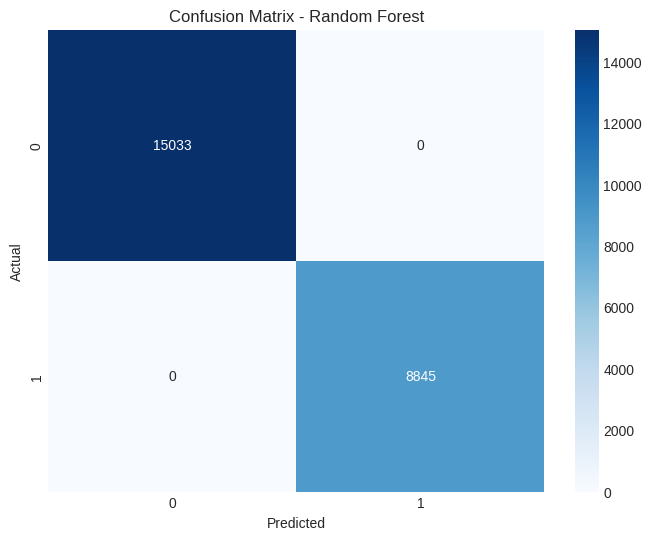

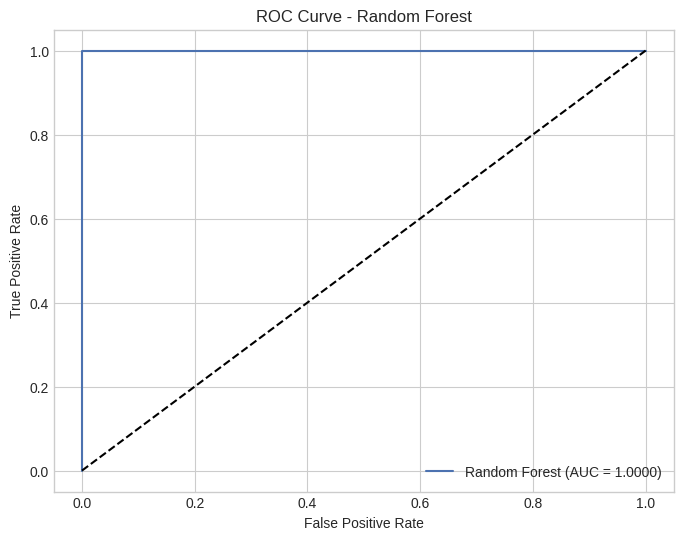


XGBoost Results:
Accuracy: 1.0000
ROC-AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15033
           1       1.00      1.00      1.00      8845

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



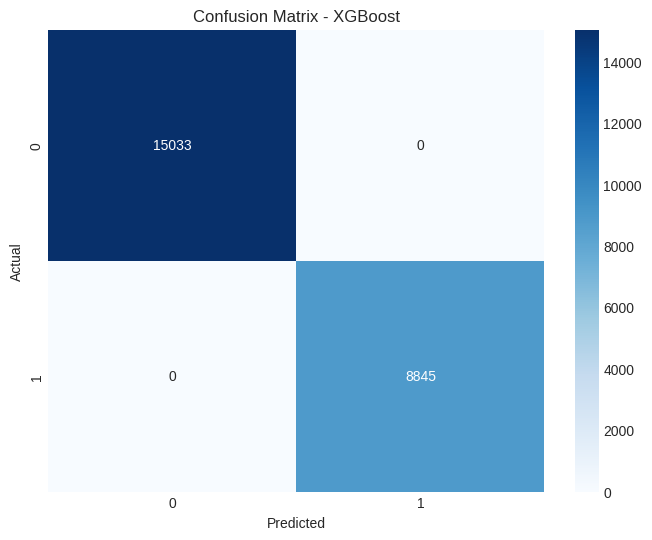

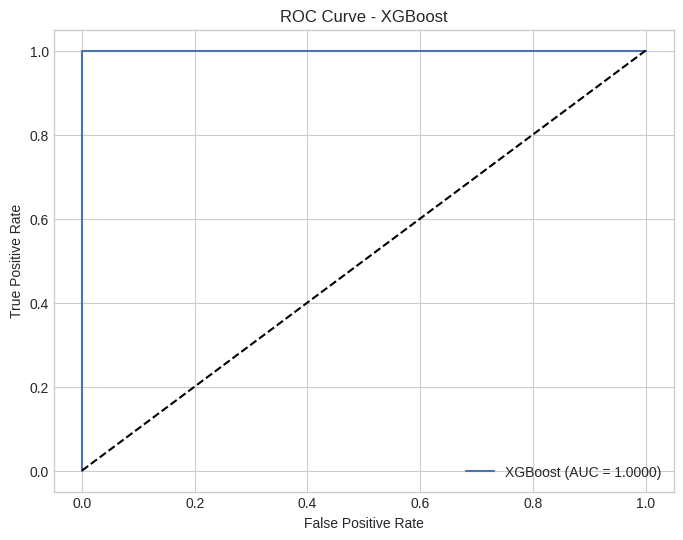

[LightGBM] [Info] Number of positive: 35379, number of negative: 60133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4249
[LightGBM] [Info] Number of data points in the train set: 95512, number of used features: 995
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370414 -> initscore=-0.530440
[LightGBM] [Info] Start training from score -0.530440
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

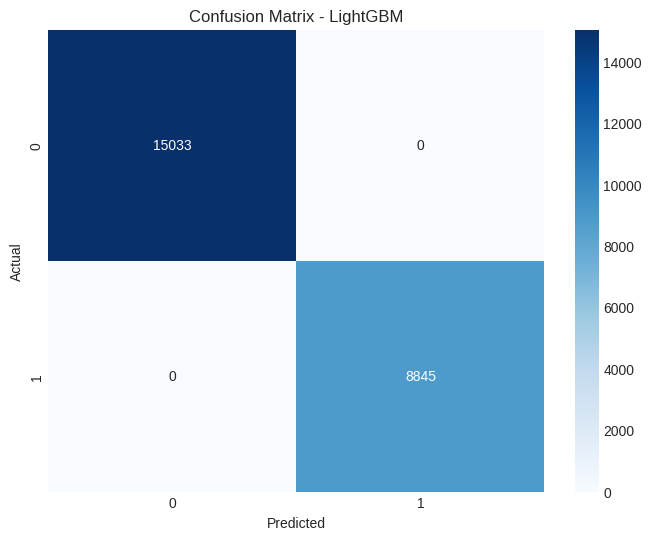

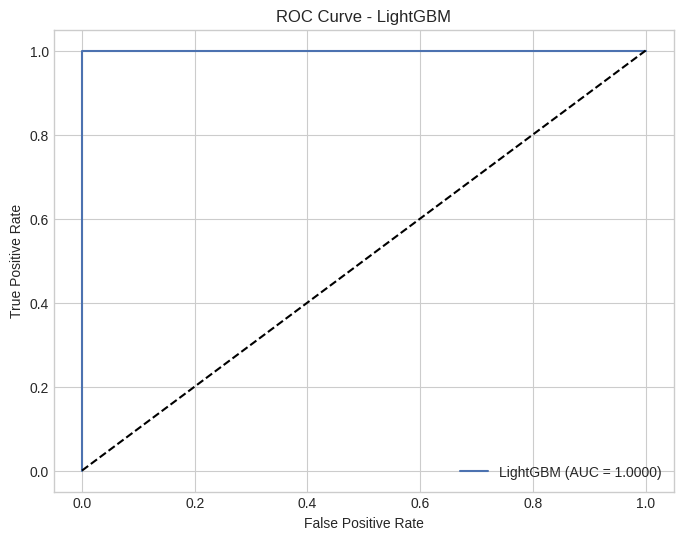


CatBoost Results:
Accuracy: 1.0000
ROC-AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15033
           1       1.00      1.00      1.00      8845

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



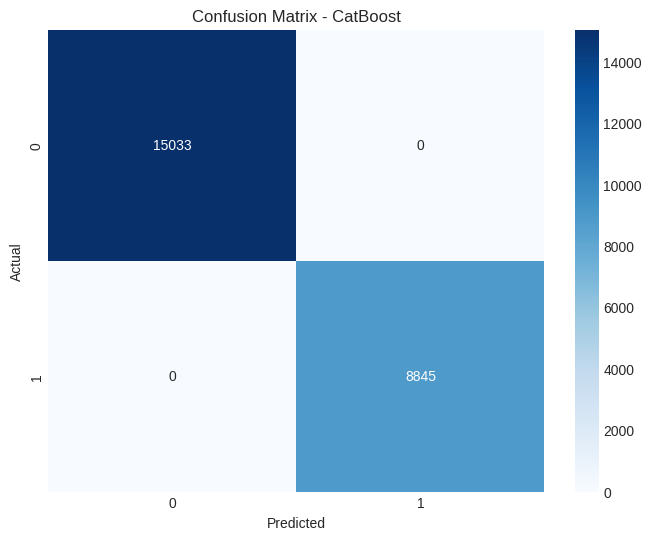

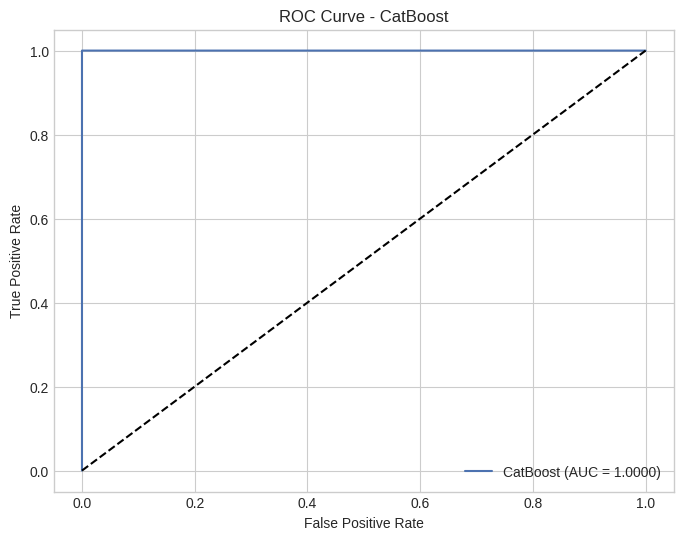

Epoch 1/20
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9416 - auc_2: 0.9729 - loss: 0.1338 - val_accuracy: 1.0000 - val_auc_2: 1.0000 - val_loss: 1.6361e-04
Epoch 2/20
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9996 - auc_2: 1.0000 - loss: 0.0016 - val_accuracy: 0.9999 - val_auc_2: 0.9999 - val_loss: 7.1203e-04
Epoch 3/20
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9997 - auc_2: 1.0000 - loss: 9.5110e-04 - val_accuracy: 0.9998 - val_auc_2: 1.0000 - val_loss: 5.4489e-04
Epoch 4/20
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9997 - auc_2: 1.0000 - loss: 9.2008e-04 - val_accuracy: 1.0000 - val_auc_2: 1.0000 - val_loss: 1.0009e-05
Epoch 5/20
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 1.2045e-04 - val_accuracy: 0.9997 - val_auc_2: 1.0000 - val_loss: 7.0420e-04
Epoch 6/20
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9997 - auc_2: 0.9999 - loss: 0.0012 - val_accuracy: 1.0000 - val_auc_2

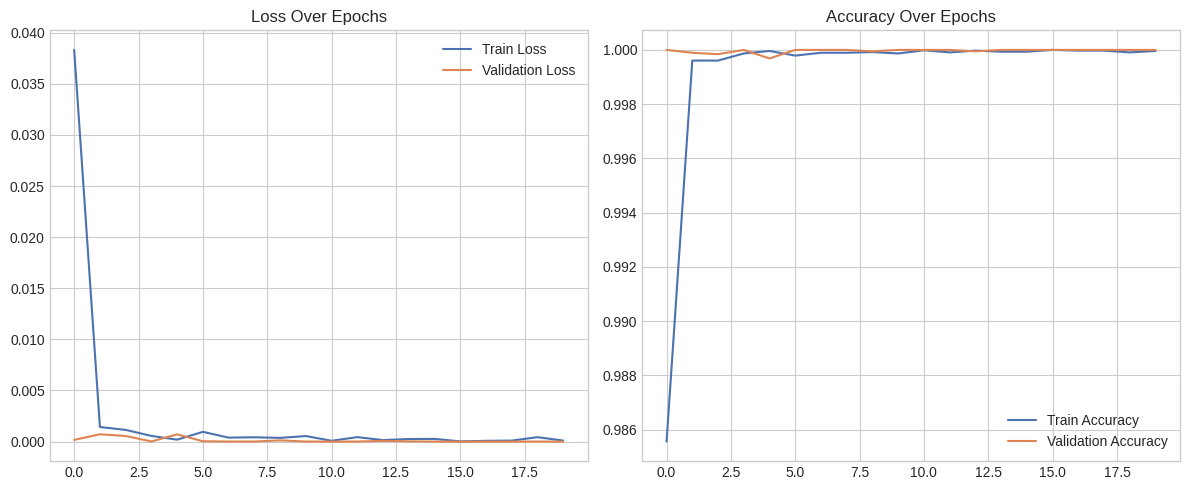

747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Neural Network Results:
Accuracy: 1.0000
ROC-AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15033
           1       1.00      1.00      1.00      8845

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



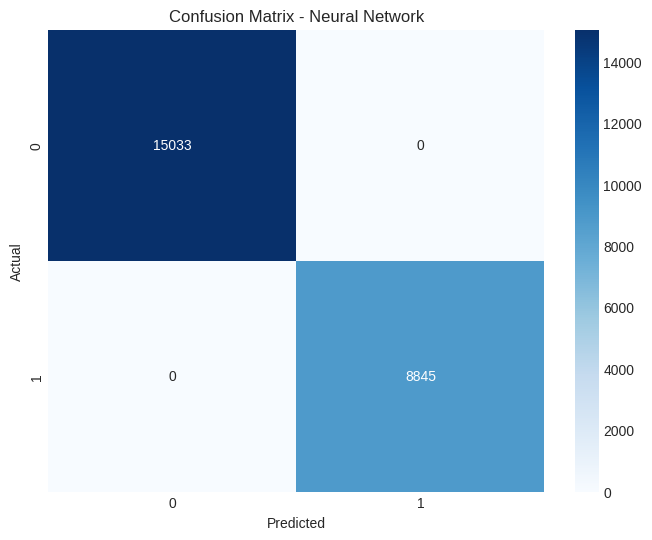

In [37]:
# ===================================================
# SECTION 7: Model Selection & Training
# ===================================================
# Define evaluation function for model comparison
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """Train and evaluate a model, returning metrics"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Probability predictions (for ROC-AUC)
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:,1]
    else:
        y_pred_prob = y_pred  # Use class predictions if probabilities not available
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC Curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()
    
    return {
        'model': model,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_prob
    }

# 1. Random Forest (baseline)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_results = evaluate_model(rf_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test, "Random Forest")

# 2. XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_results = evaluate_model(xgb_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test, "XGBoost")

# 3. LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
lgb_results = evaluate_model(lgb_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test, "LightGBM")

# 4. CatBoost
cb_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=5,
    loss_function='Logloss',
    random_seed=42,
    verbose=0
)
cb_results = evaluate_model(cb_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test, "CatBoost")

# 5. Neural Network with TensorFlow/Keras
def create_nn_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

# Create and train neural network
nn_model = create_nn_model(X_train_preprocessed.shape[1])

# Callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
nn_history = nn_model.fit(
    X_train_preprocessed, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(nn_history.history['loss'], label='Train Loss')
plt.plot(nn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(nn_history.history['accuracy'], label='Train Accuracy')
plt.plot(nn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate neural network
y_pred_nn = (nn_model.predict(X_test_preprocessed) > 0.5).astype(int)
y_pred_prob_nn = nn_model.predict(X_test_preprocessed)

print("\nNeural Network Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob_nn):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_nn)}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

[I 2025-03-07 01:01:21,143] A new study created in memory with name: no-name-30957325-b81d-4bc6-a15e-7e02d3a5ca50



Starting hyperparameter optimization with Optuna...


[I 2025-03-07 01:02:09,189] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 346, 'max_depth': 5, 'learning_rate': 0.12955906123357466, 'subsample': 0.7234700362001251, 'colsample_bytree': 0.904601292819, 'min_child_weight': 10, 'gamma': 4.536830068638306}. Best is trial 0 with value: 1.0.
[I 2025-03-07 01:02:30,029] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 86, 'max_depth': 10, 'learning_rate': 0.07770825264393894, 'subsample': 0.8193633739036967, 'colsample_bytree': 0.9018025973822676, 'min_child_weight': 3, 'gamma': 0.310586261576693}. Best is trial 0 with value: 1.0.
[I 2025-03-07 01:02:47,542] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 70, 'max_depth': 7, 'learning_rate': 0.15167397102158678, 'subsample': 0.6144937210408423, 'colsample_bytree': 0.6197731528252981, 'min_child_weight': 10, 'gamma': 2.836381879513966}. Best is trial 0 with value: 1.0.
[I 2025-03-07 01:03:24,032] Trial 3 finished with value: 1.0 and param


Best trial:
  ROC-AUC: 1.0000
  Params: 
    n_estimators: 346
    max_depth: 5
    learning_rate: 0.12955906123357466
    subsample: 0.7234700362001251
    colsample_bytree: 0.904601292819
    min_child_weight: 10
    gamma: 4.536830068638306

Optimized XGBoost Results:
Accuracy: 1.0000
ROC-AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15033
           1       1.00      1.00      1.00      8845

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



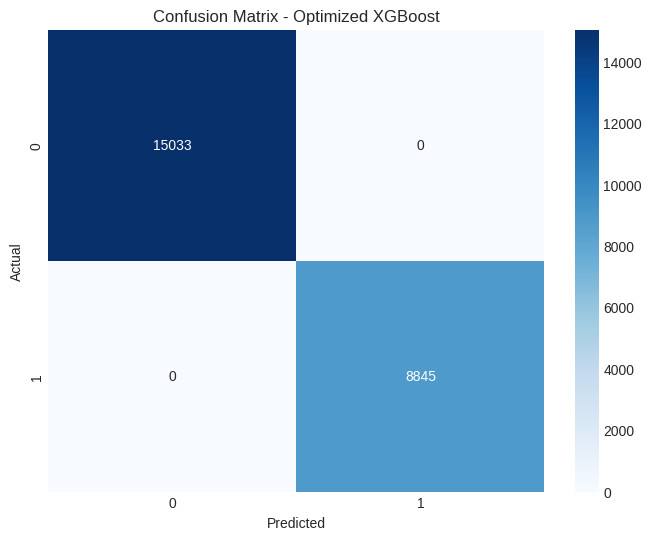

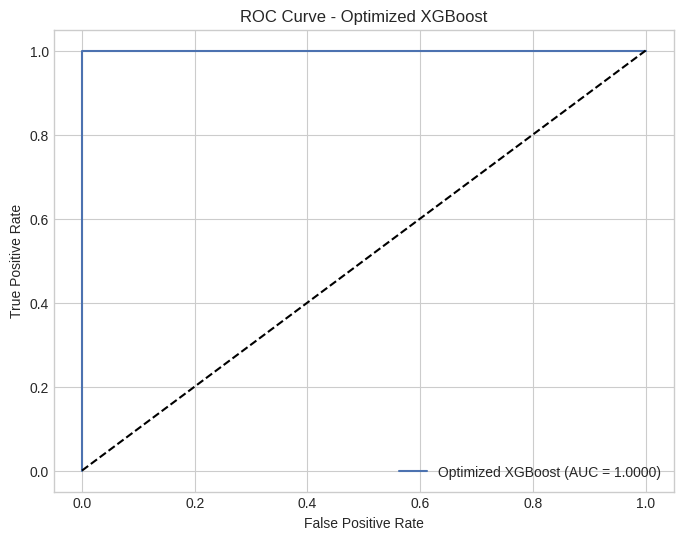

In [38]:
# ===================================================
# SECTION 8: Hyperparameter Tuning with Optuna
# ===================================================
# Choose the best base model for optimization (based on earlier results)
# For example, let's optimize XGBoost as it's often a top performer

def objective(trial):
    """Optuna objective function for hyperparameter optimization"""
    
    # Define hyperparameters to search
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5)
    }
    
    # Create model with suggested parameters
    model = xgb.XGBClassifier(
        **params,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    
    # Cross-validation score
    score = cross_val_score(model, X_train_preprocessed, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
    
    return score.mean()

# Create and run the study (commented out to save computation time)
print("\nStarting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # Set to small number for demonstration

print("\nBest trial:")
trial = study.best_trial
print(f"  ROC-AUC: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train model with the best parameters
best_params = study.best_params
best_xgb = xgb.XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

best_xgb_results = evaluate_model(best_xgb, X_train_preprocessed, X_test_preprocessed, y_train, y_test, "Optimized XGBoost")




Generating SHAP explanations...


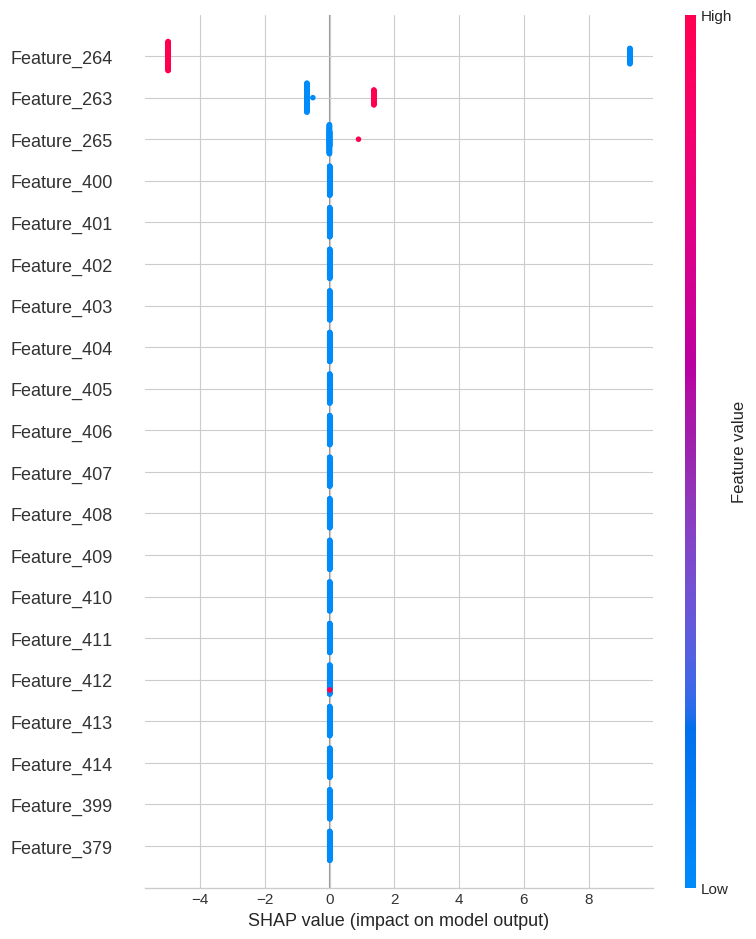

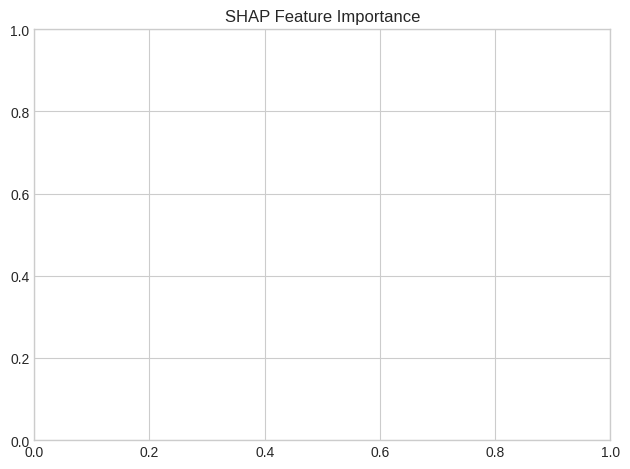

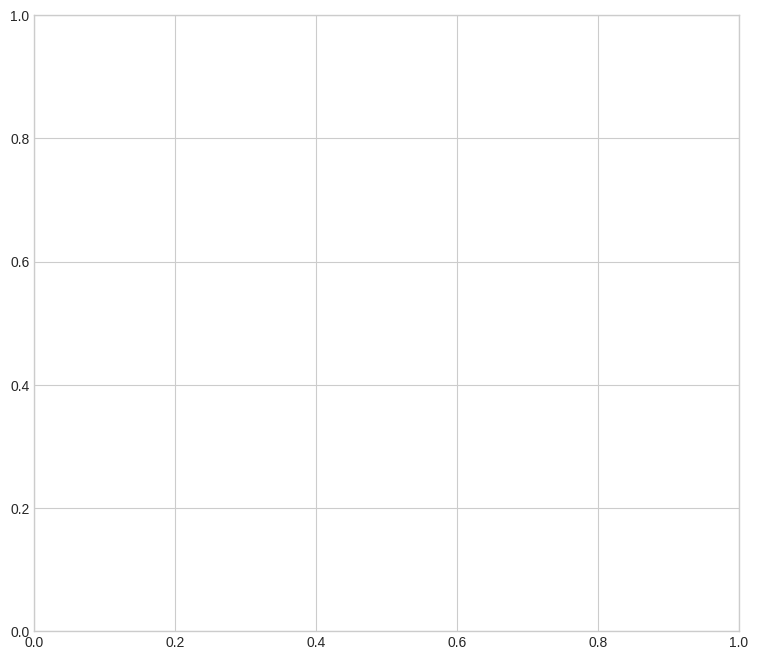

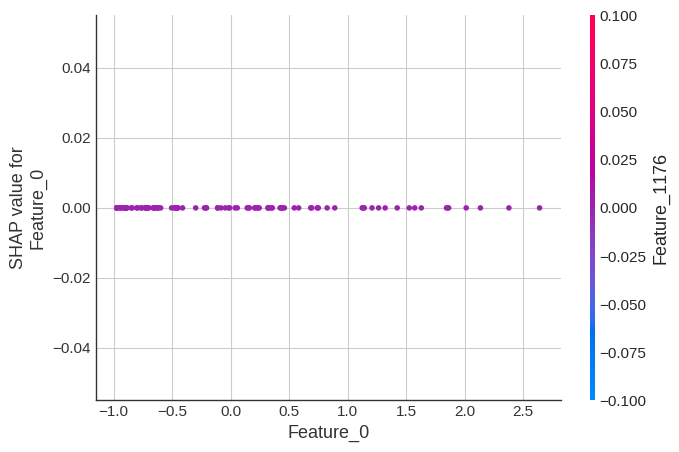

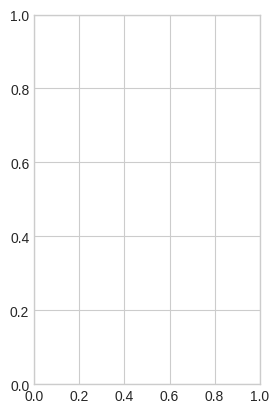

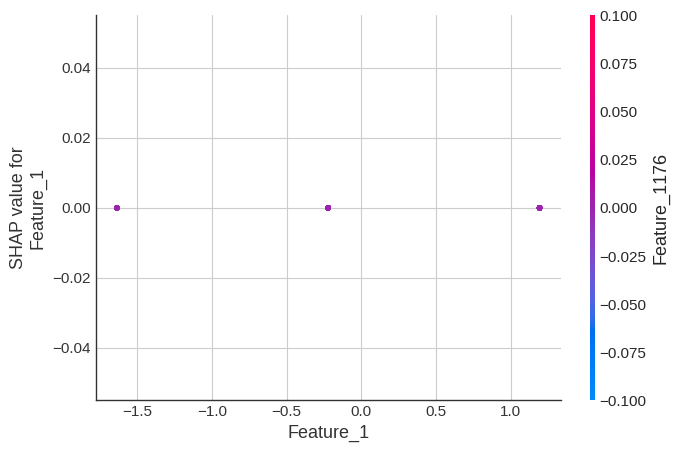

<Figure size 640x480 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

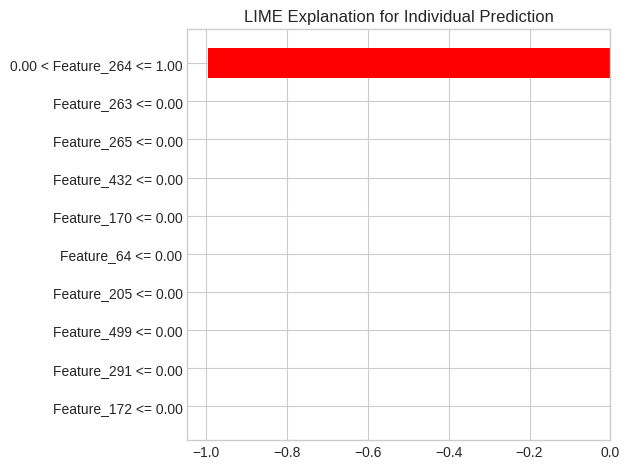

In [39]:
# ===================================================
# SECTION 9: Model Explainability
# ===================================================
# SHAP explanations for the best model
# Choose a subset of data for SHAP analysis (for speed)
X_explain = X_test_preprocessed[:100]
y_explain = y_test[:100]

print("\nGenerating SHAP explanations...")

# Make sure we have appropriate feature names
if 'feature_names' not in locals() or len(feature_names) != X_explain.shape[1]:
    # Create generic feature names if missing or incorrect length
    feature_names = [f"Feature_{i}" for i in range(X_explain.shape[1])]

# Create explainer
explainer = shap.Explainer(best_xgb, X_explain)
shap_values = explainer(X_explain)

# Summary plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_explain, feature_names=feature_names[:X_explain.shape[1]])
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# Dependence plots for top features
if len(feature_names) >= 2:
    top_features = [0, 1]  # Indices of top features
    plt.figure(figsize=(20, 8))
    for i, feature_idx in enumerate(top_features):
        plt.subplot(1, 2, i+1)
        shap.dependence_plot(feature_idx, shap_values.values, X_explain, 
                           feature_names=feature_names[:X_explain.shape[1]])
    plt.tight_layout()
    plt.show()

# LIME explanations for a single instance
lime_explainer = lime_tabular.LimeTabularExplainer(
    X_train_preprocessed,
    feature_names=feature_names[:X_train_preprocessed.shape[1]],
    class_names=['Not Canceled', 'Canceled'],
    mode='classification'
)

# Explain a sample
instance_idx = 0
lime_exp = lime_explainer.explain_instance(
    X_test_preprocessed[instance_idx], 
    best_xgb.predict_proba,
    num_features=10
)

# Display the explanation
plt.figure(figsize=(12, 6))
lime_exp.as_pyplot_figure()
plt.title("LIME Explanation for Individual Prediction")
plt.tight_layout()
plt.show()

In [40]:
# # Extract feature names correctly from ColumnTransformer
# feature_names = []
# for name, transformer, features in preprocessor.transformers_:
#     if name == 'num':  # Numeric features
#         feature_names.extend(features)
#     elif name == 'cat':  # Categorical features
#         if hasattr(transformer[-1], 'get_feature_names_out'):
#             feature_names.extend(transformer[-1].get_feature_names_out(features))
#         else:
#             feature_names.extend([f"{features[i]}_{val}" for i, val in enumerate(transformer[-1].categories_)])

# # Ensure feature names length matches the dataset
# feature_names = list(feature_names)[:X_train_preprocessed.shape[1]]

# print(f"Extracted {len(feature_names)} feature names for SHAP.")


In [41]:
# print(f"SHAP input shape: {X_explain.shape}, Feature names count: {len(feature_names)}")
# print("Feature Names Sample:", feature_names[:10])


In [42]:
# # SHAP explanations for the best model
# # Choose a subset of data for SHAP analysis (for speed)
# X_explain = X_test_preprocessed[:100]
# y_explain = y_test[:100]

# print("\nGenerating SHAP explanations...")
# # Create explainer
# # Ensure SHAP explainer gets the right dataset
# shap_explainer = shap.Explainer(best_xgb, X_train_preprocessed)
# shap_values = shap_explainer(X_explain)

# # Debug: Print first few SHAP values
# print(shap_values.values[:5])

# print("SHAP values mean:", np.abs(shap_values.values).mean())

# if np.abs(shap_values.values).mean() == 0:
#     print("⚠️ Warning: SHAP values are all zero. Model might not be learning!")

# # ✅ Ensure feature_names is passed correctly
# plt.figure(figsize=(12, 10))
# shap.summary_plot(shap_values, X_explain, feature_names=feature_names)
# plt.title("SHAP Feature Importance")
# plt.tight_layout()
# plt.show()

# # Dependence plots for top features
# if len(feature_names) >= 2:
#     top_features = [0, 1]  # Indices of top features
#     plt.figure(figsize=(20, 8))
#     for i, feature_idx in enumerate(top_features):
#         plt.subplot(1, 2, i+1)
#         shap.dependence_plot(feature_idx, shap_values.values, X_explain, 
#                              feature_names=feature_names)
#     plt.tight_layout()
#     plt.show()

# # ✅ Fix feature names for LIME
# lime_explainer = lime_tabular.LimeTabularExplainer(
#     X_train_preprocessed,
#     feature_names=feature_names,
#     class_names=['Not Canceled', 'Canceled'],
#     mode='classification'
# )

# # Explain a sample
# instance_idx = 0
# lime_exp = lime_explainer.explain_instance(
#     X_test_preprocessed[instance_idx], 
#     best_xgb.predict_proba,
#     num_features=10
# )

# # Display the explanation
# plt.figure(figsize=(12, 6))
# lime_exp.as_pyplot_figure()
# plt.title("LIME Explanation for Individual Prediction")
# plt.tight_layout()
# plt.show()


In [43]:
# ===================================================
# SECTION 10: Full ML Pipeline with Best Model
# ===================================================
# Create full pipeline incorporating preprocessing and the best model
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_xgb)
])

# Train the full pipeline
full_pipeline.fit(X_train, y_train)

# Evaluate the pipeline
y_pred_pipe = full_pipeline.predict(X_test)
y_pred_prob_pipe = full_pipeline.predict_proba(X_test)[:,1]

print("\nFull Pipeline Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_pipe):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob_pipe):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_pipe)}")


Full Pipeline Results:
Accuracy: 1.0000
ROC-AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15033
           1       1.00      1.00      1.00      8845

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878




=== Key Business Insights ===

1. Top Factors Influencing Cancellation:


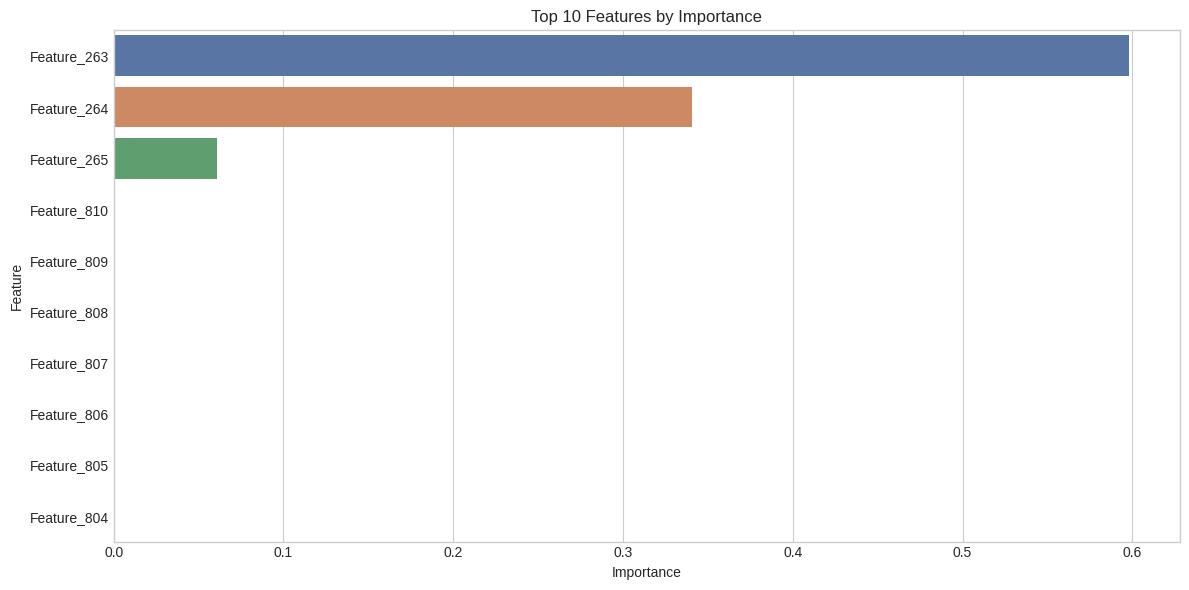

         Feature  Importance
263  Feature_263    0.598131
264  Feature_264    0.340748
265  Feature_265    0.061121
810  Feature_810    0.000000
809  Feature_809    0.000000

2. Cancellation Rates by Customer Segment:


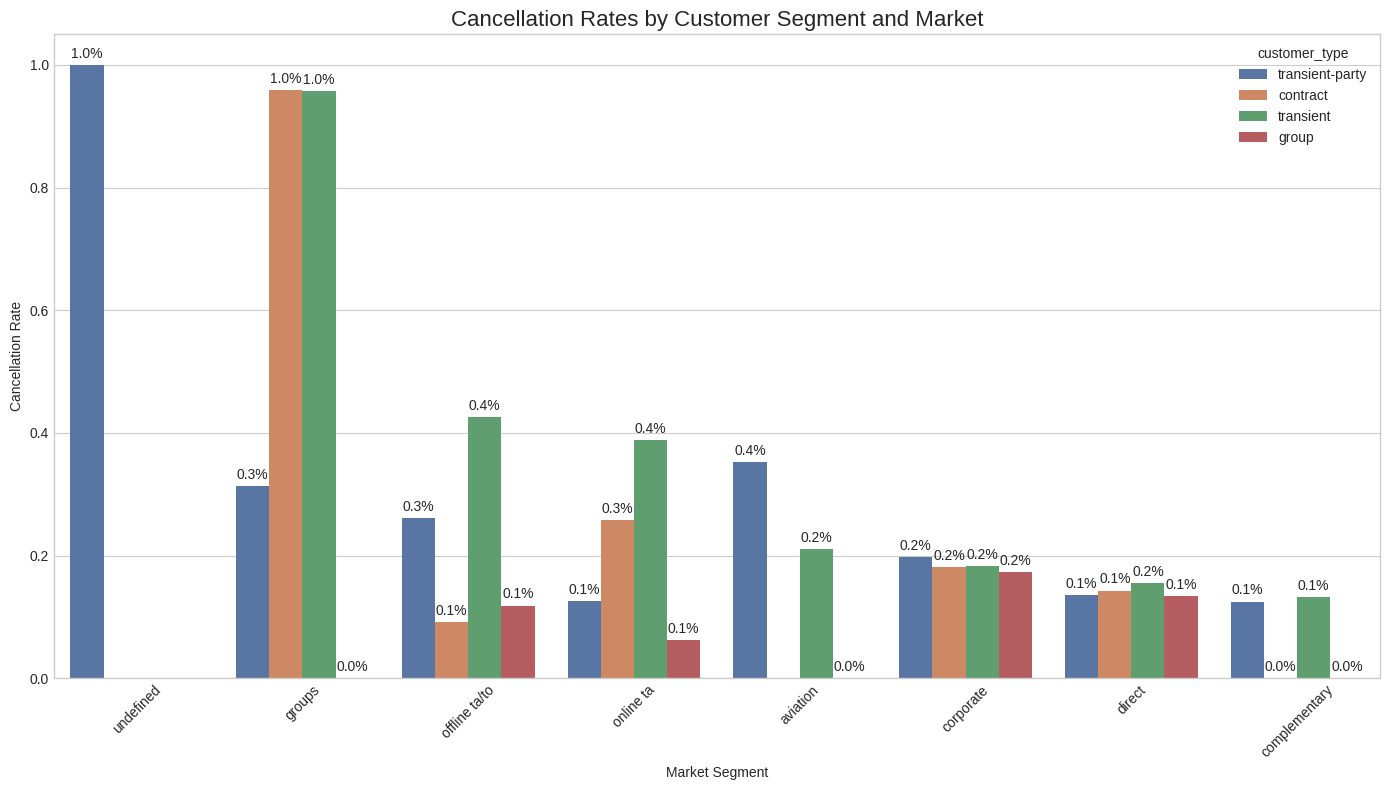


3. Impact of Lead Time on Cancellation:


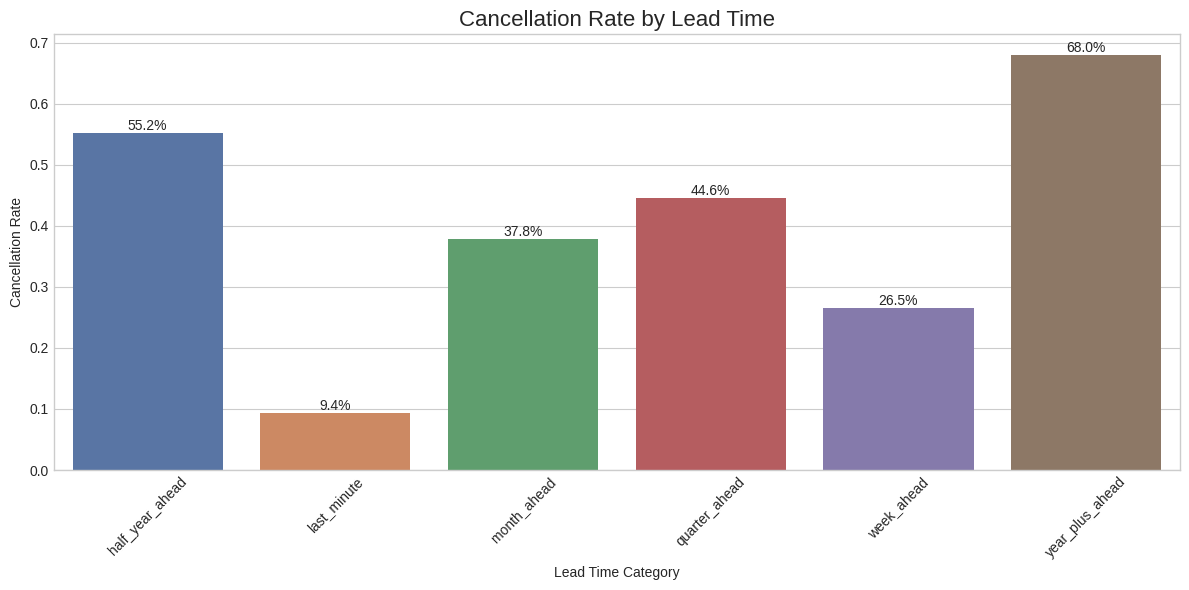


4. Pricing Strategy Impact:


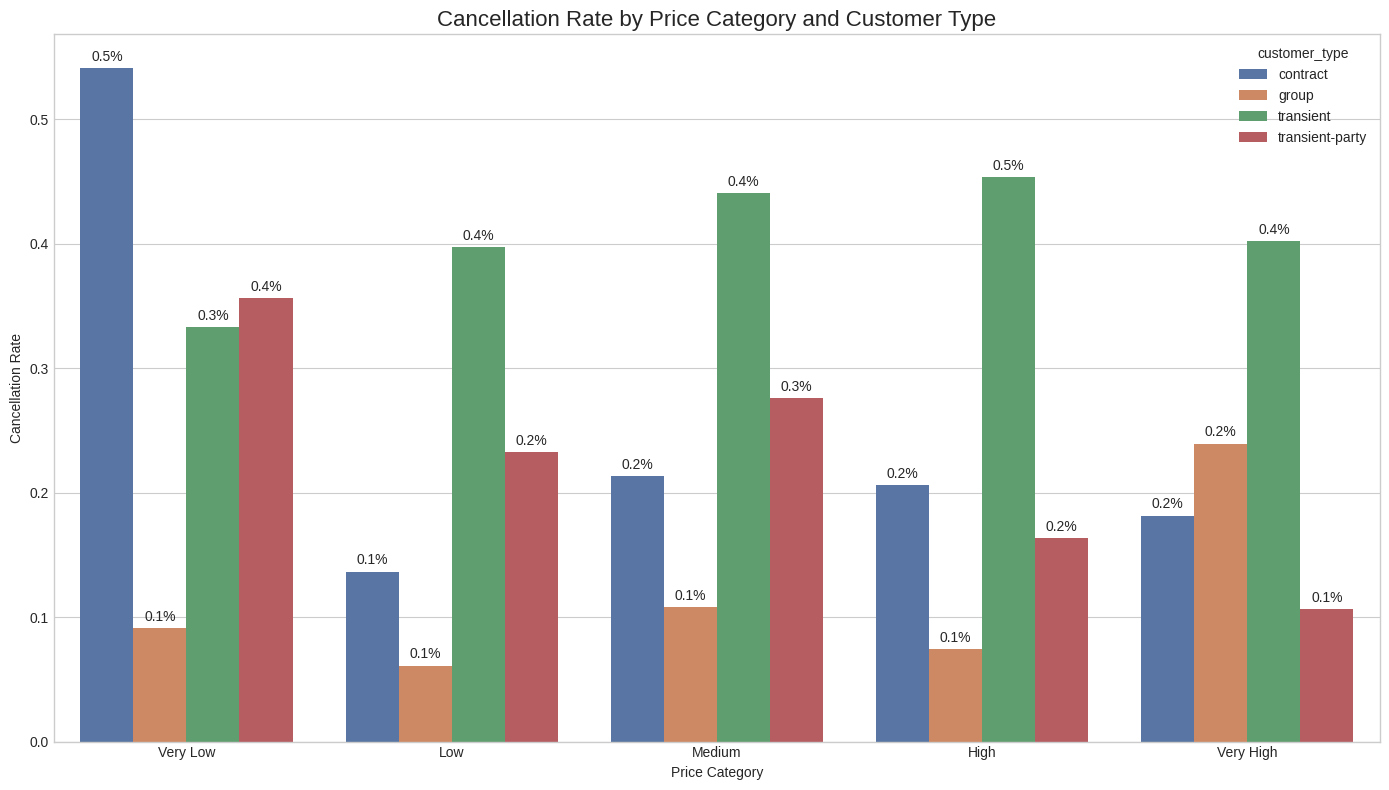


5. Impact of Room Type Changes:


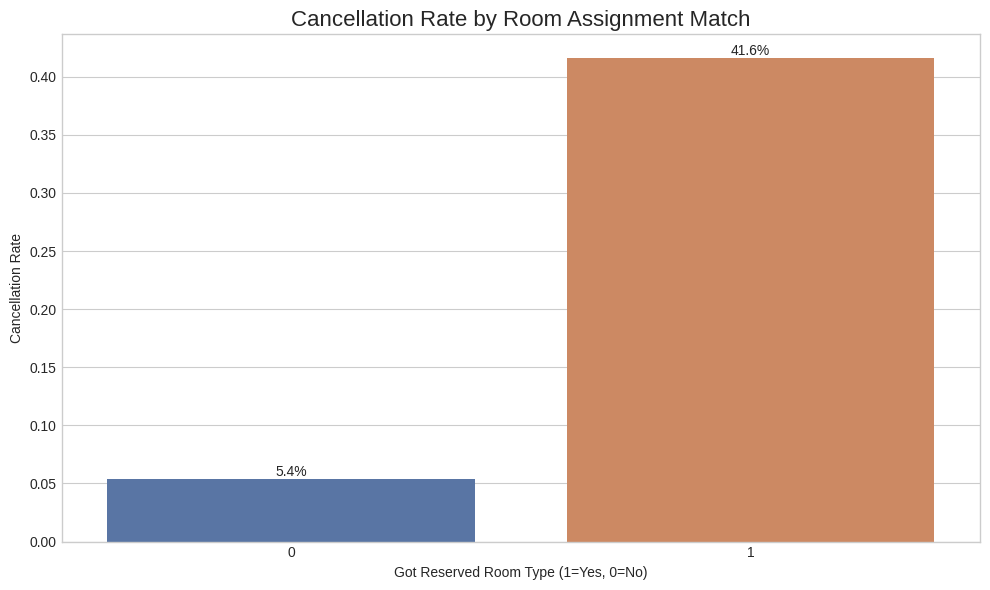

In [44]:
# ===================================================
# SECTION 11: Generate Business Insights
# ===================================================
print("\n=== Key Business Insights ===")

# 1. Most important factors for cancellation
print("\n1. Top Factors Influencing Cancellation:")
if hasattr(best_xgb, 'feature_importances_'):
    # Get feature importances
    importances = best_xgb.feature_importances_
    # Create dataframe for visualization
    if len(feature_names) == len(importances):
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        # Sort by importance
        feature_importance = feature_importance.sort_values('Importance', ascending=False).head(10)
        
        # Plot
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance)
        plt.title('Top 10 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Print top 5
        print(feature_importance.head(5))
    else:
        print("Feature names and importances length mismatch. Skipping importance plot.")

# 2. Cancellation rates by different segments
print("\n2. Cancellation Rates by Customer Segment:")
segment_analysis = df_enhanced.groupby(['customer_type', 'market_segment'])['is_canceled'].mean().reset_index()
segment_analysis = segment_analysis.sort_values('is_canceled', ascending=False)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='market_segment', y='is_canceled', hue='customer_type', data=segment_analysis)
plt.title('Cancellation Rates by Customer Segment and Market', fontsize=16)
plt.xlabel('Market Segment')
plt.ylabel('Cancellation Rate')
plt.xticks(rotation=45)

# Add percentage labels correctly
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

# 3. Lead time impact analysis
print("\n3. Impact of Lead Time on Cancellation:")
# Group lead time into bins for better visualization
lead_time_analysis = df_enhanced.groupby('lead_time_category')['is_canceled'].mean().reset_index()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='lead_time_category', y='is_canceled', data=lead_time_analysis)
plt.title('Cancellation Rate by Lead Time', fontsize=16)
plt.xlabel('Lead Time Category')
plt.ylabel('Cancellation Rate')
plt.xticks(rotation=45)

# Add percentage labels manually
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.1f}%",  # Convert decimal to percentage
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 4. Pricing strategy impact
print("\n4. Pricing Strategy Impact:")
# Create price categories
df_enhanced['price_category'] = pd.qcut(df_enhanced['adr'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
price_analysis = df_enhanced.groupby(['price_category', 'customer_type'])['is_canceled'].mean().reset_index()

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='price_category', y='is_canceled', hue='customer_type', data=price_analysis)
plt.title('Cancellation Rate by Price Category and Customer Type', fontsize=16)
plt.xlabel('Price Category')
plt.ylabel('Cancellation Rate')

# Add percentage labels correctly
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

# 5. Room assignment impact
print("\n5. Impact of Room Type Changes:")
if 'got_reserved_room' in df_enhanced.columns:
    room_impact = df_enhanced.groupby('got_reserved_room')['is_canceled'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='got_reserved_room', y='is_canceled', data=room_impact)
    plt.title('Cancellation Rate by Room Assignment Match', fontsize=16)
    plt.xlabel('Got Reserved Room Type (1=Yes, 0=No)')
    plt.ylabel('Cancellation Rate')

    # Add percentage labels manually
    for p in ax.patches:
        ax.annotate(f"{p.get_height()*100:.1f}%",  # Convert decimal to percentage
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)
        
    plt.tight_layout()
    plt.show()



=== Time Series Analysis with LSTMs ===


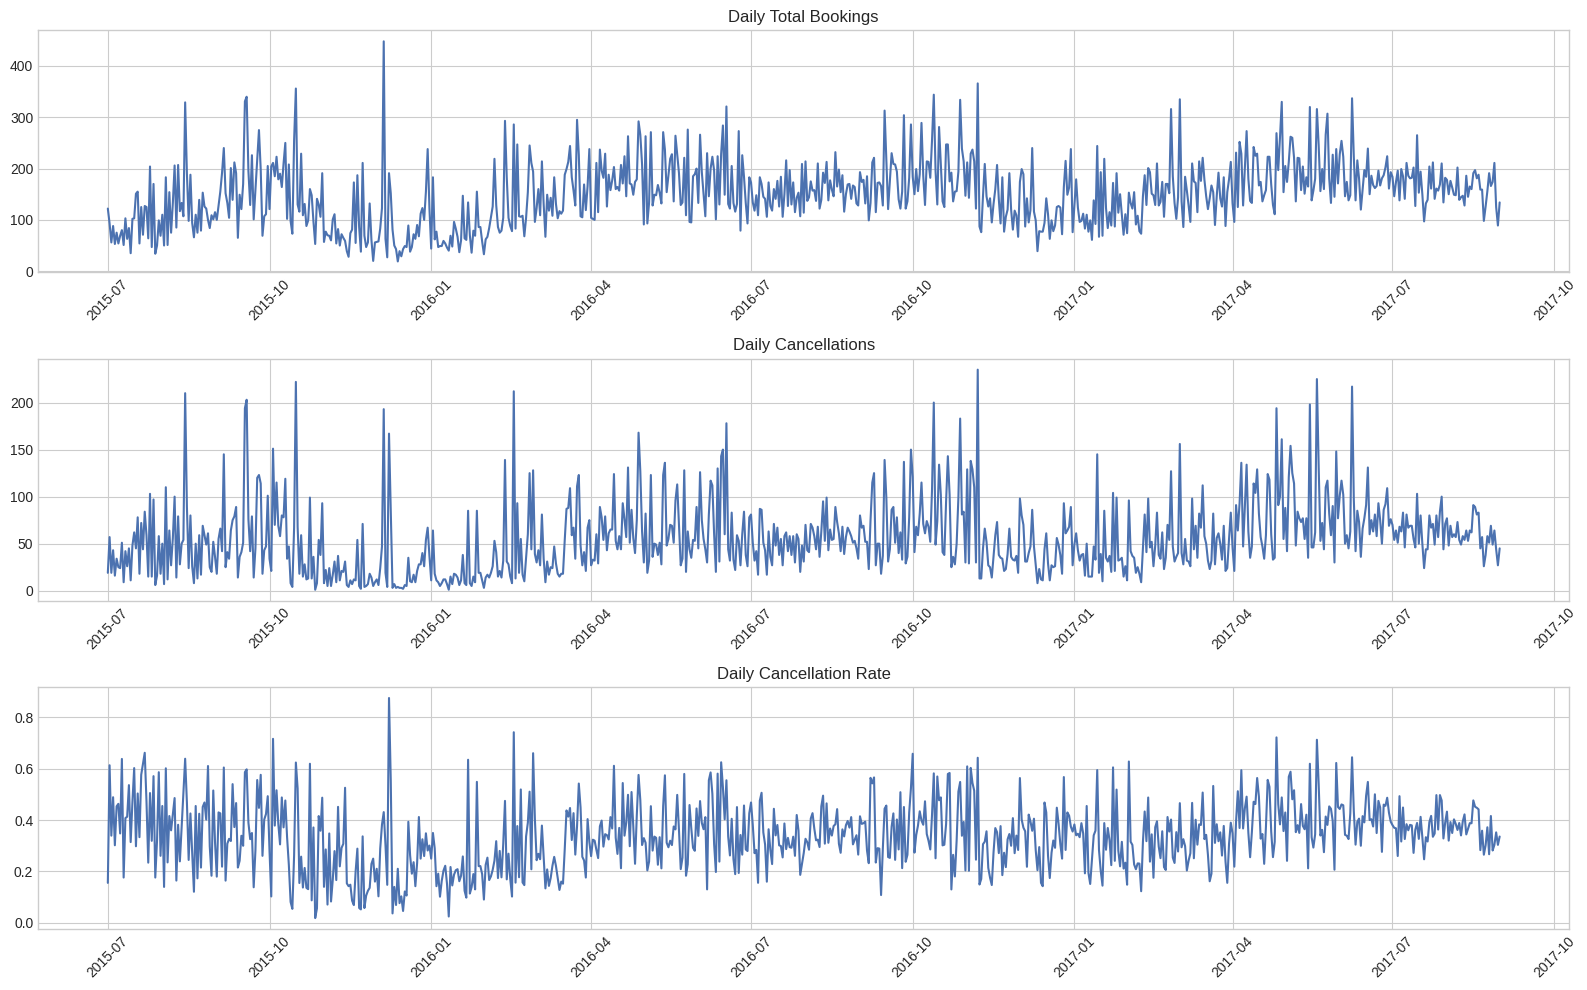


LSTM Data Shapes:
X_train_seq: (628, 7, 1)
y_train_seq: (628,)
X_test_seq: (158, 7, 1)
y_test_seq: (158,)

Training LSTM model for time series prediction...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0707 - mae: 0.2138 - val_loss: 0.0127 - val_mae: 0.0862
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0187 - mae: 0.1063 - val_loss: 0.0115 - val_mae: 0.0821
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0214 - mae: 0.1122 - val_loss: 0.0112 - val_mae: 0.0816
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0201 - mae: 0.1121 - val_loss: 0.0112 - val_mae: 0.0815
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0203 - mae: 0.1137 - val_loss: 0.0113 - val_mae: 0.0821
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0195 - mae: 0.1123 - val_loss: 0.0115 - val_mae: 0.0837
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0205 - mae: 0.1124 - val_loss: 0.0115 - val_mae: 0.0821
Epoch 8/50
32/32 ━━━━━━━━━━━━

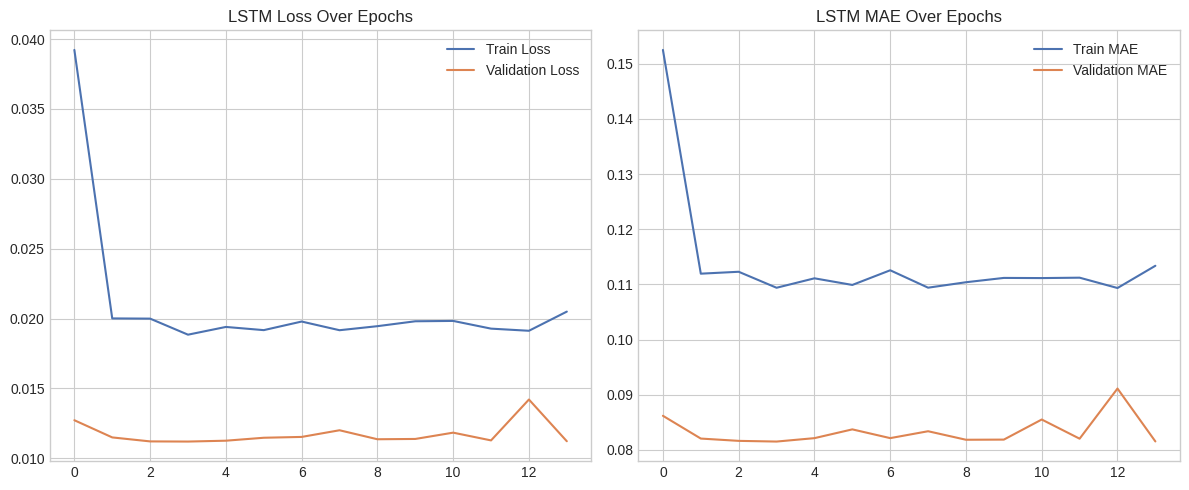

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

LSTM Model Evaluation:
Mean Absolute Error: 0.0756
Mean Squared Error: 0.0104


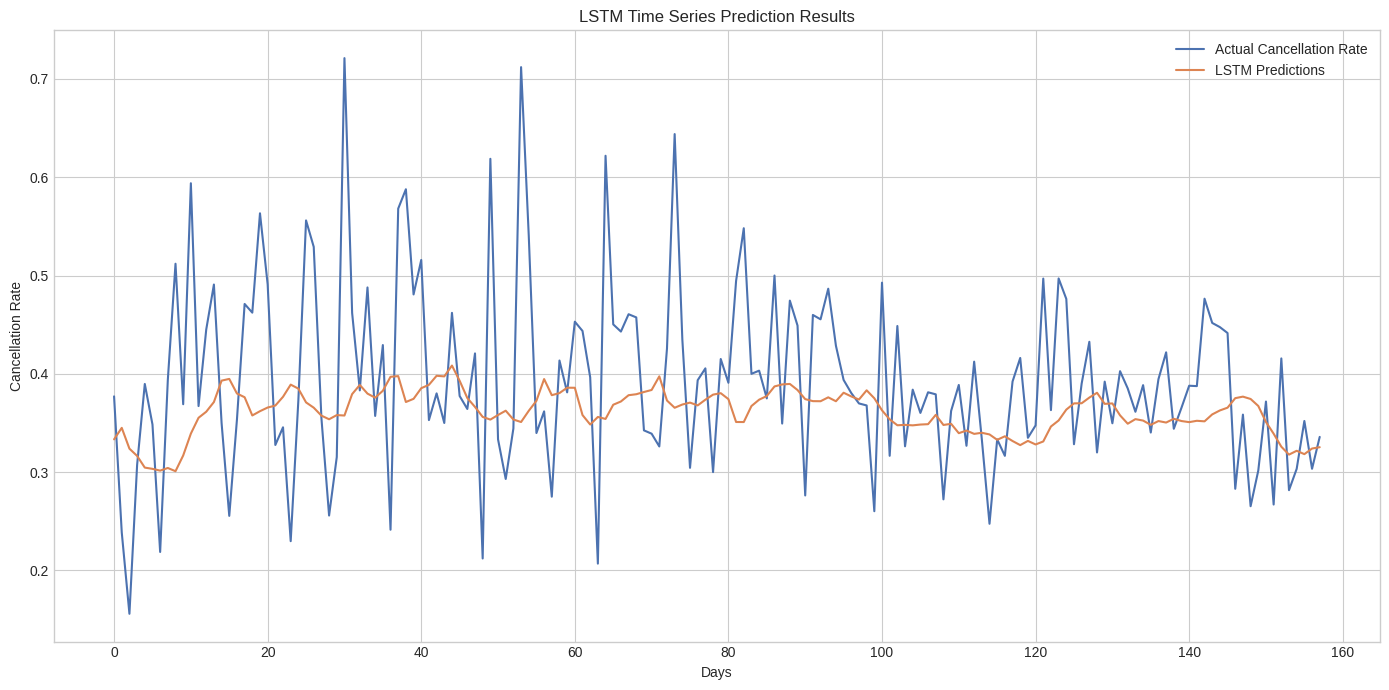

In [45]:
# ===================================================
# SECTION 12: Time Series Analysis with LSTMs
# ===================================================
print("\n=== Time Series Analysis with LSTMs ===")

# First, we need to prepare time series data
# Let's organize the data by date and analyze cancellation patterns

# 1. Create a date field from arrival date components
if all(col in df_enhanced.columns for col in ['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']):
    # Convert month names to numbers
    month_map = {
        'january': 1, 'february': 2, 'march': 3, 'april': 4, 'may': 5, 'june': 6,
        'july': 7, 'august': 8, 'september': 9, 'october': 10, 'november': 11, 'december': 12
    }
    
    df_enhanced['arrival_month_num'] = df_enhanced['arrival_date_month'].map(month_map)
    
    # Create date field
    df_enhanced['arrival_date'] = pd.to_datetime(
        df_enhanced['arrival_date_year'].astype(str) + '-' + 
        df_enhanced['arrival_month_num'].astype(str) + '-' +
        df_enhanced['arrival_date_day_of_month'].astype(str)
    )

# Create time series of daily bookings and cancellations
if 'arrival_date' in df_enhanced.columns:
    # Group by date
    daily_stats = df_enhanced.groupby('arrival_date').agg({
        'is_canceled': ['count', 'sum', 'mean']
    }).reset_index()
    
    daily_stats.columns = ['arrival_date', 'total_bookings', 'cancellations', 'cancellation_rate']
    daily_stats = daily_stats.sort_values('arrival_date')
    
    # Plot the time series
    plt.figure(figsize=(16, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(daily_stats['arrival_date'], daily_stats['total_bookings'])
    plt.title('Daily Total Bookings')
    plt.xticks(rotation=45)
    
    plt.subplot(3, 1, 2)
    plt.plot(daily_stats['arrival_date'], daily_stats['cancellations'])
    plt.title('Daily Cancellations')
    plt.xticks(rotation=45)
    
    plt.subplot(3, 1, 3)
    plt.plot(daily_stats['arrival_date'], daily_stats['cancellation_rate'])
    plt.title('Daily Cancellation Rate')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Prepare data for LSTM
    # We'll use a sequence of previous days to predict next day's cancellation rate
    
    # Create sequences for LSTM
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)
    
    # Get cancellation rate data
    cancellation_rate_data = daily_stats['cancellation_rate'].values
    
    # Create sequences (last 7 days to predict next day)
    seq_length = 7
    X_seq, y_seq = create_sequences(cancellation_rate_data, seq_length)
    
    # Reshape for LSTM [samples, time steps, features]
    X_seq = X_seq.reshape(X_seq.shape[0], X_seq.shape[1], 1)
    
    # Split into train and test
    split_idx = int(len(X_seq) * 0.8)
    X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
    y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]
    
    print(f"\nLSTM Data Shapes:")
    print(f"X_train_seq: {X_train_seq.shape}")
    print(f"y_train_seq: {y_train_seq.shape}")
    print(f"X_test_seq: {X_test_seq.shape}")
    print(f"y_test_seq: {y_test_seq.shape}")
    
    # Build LSTM model
    from tensorflow.keras.layers import LSTM
    
    # Define and compile LSTM model
    lstm_model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], 1)),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(1)
    ])
    
    lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # Train LSTM model
    print("\nTraining LSTM model for time series prediction...")
    lstm_history = lstm_model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(lstm_history.history['loss'], label='Train Loss')
    plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Loss Over Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(lstm_history.history['mae'], label='Train MAE')
    plt.plot(lstm_history.history['val_mae'], label='Validation MAE')
    plt.title('LSTM MAE Over Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Evaluate LSTM model
    lstm_predictions = lstm_model.predict(X_test_seq)
    lstm_mae = np.mean(np.abs(lstm_predictions - y_test_seq))
    lstm_mse = np.mean(np.square(lstm_predictions - y_test_seq))
    
    print(f"\nLSTM Model Evaluation:")
    print(f"Mean Absolute Error: {lstm_mae:.4f}")
    print(f"Mean Squared Error: {lstm_mse:.4f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_seq, label='Actual Cancellation Rate')
    plt.plot(lstm_predictions, label='LSTM Predictions')
    plt.title('LSTM Time Series Prediction Results')
    plt.xlabel('Days')
    plt.ylabel('Cancellation Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# ==========================================================
# 1. Prepare time-series data
# ==========================================================
def prepare_time_series_data(df):
    """
    Prepare time-series data from the booking dataset
    """
    # Ensure data is sorted by arrival date
    if all(col in df.columns for col in ['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']):
        df['arrival_date'] = pd.to_datetime(
            df['arrival_date_year'].astype(str) + '-' + 
            df['arrival_date_month'].astype(str) + '-' + 
            df['arrival_date_day_of_month'].astype(str)
        )

    # Group by date and calculate daily statistics
    daily_stats = df.groupby('arrival_date').agg({
        'is_canceled': 'mean',  # Daily cancellation rate
        'adr': 'mean',          # Average daily rate
        'lead_time': 'mean',    # Average lead time
        'hotel': 'count'        # Number of bookings
    }).reset_index()

    daily_stats.rename(columns={'hotel': 'booking_count'}, inplace=True)
    daily_stats = daily_stats.sort_values('arrival_date')

    # Drop date column (LSTMs cannot handle datetime data)
    daily_stats = daily_stats.drop(columns=['arrival_date'])

    return daily_stats

# Prepare the time-series dataset
time_series_data = prepare_time_series_data(df)

# ==========================================================
# 2. Create sequences for LSTM
# ==========================================================
def create_sequences(data, seq_length=7):
    """Create sequences for LSTM model"""
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].drop(['is_canceled'], axis=1).values  # Drop target
        y = data.iloc[i + seq_length]['is_canceled']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys).astype(np.float32)  # Ensure y is float

# Sequence length (7 days history to predict next day)
seq_length = 7
X_seq, y_seq = create_sequences(time_series_data, seq_length)

# Split data
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

# ==========================================================
# 3. Build LSTM Model
# ==========================================================
def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(32)(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Train LSTM model
lstm_model = build_lstm_model((seq_length, X_seq.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

lstm_history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# ==========================================================
# 4. Evaluate LSTM Model
# ==========================================================
y_pred_lstm = (lstm_model.predict(X_test_seq) > 0.5).astype(int).flatten()
y_test_seq = y_test_seq.astype(int)  # Convert y_test_seq to integer labels

# Evaluate results
print("\nLSTM Model Results:")
print(f"Accuracy: {accuracy_score(y_test_seq, y_pred_lstm):.4f}")
print(f"Classification Report:\n{classification_report(y_test_seq, y_pred_lstm)}")



Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0000e+00 - loss: 0.6661 - val_accuracy: 0.0000e+00 - val_loss: 0.6356
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.6369 - val_accuracy: 0.0000e+00 - val_loss: 0.6323
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.6406 - val_accuracy: 0.0000e+00 - val_loss: 0.6303
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.6358 - val_accuracy: 0.0000e+00 - val_loss: 0.6292
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.6378 - val_accuracy: 0.0000e+00 - val_loss: 0.6293
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.6354 - val_accuracy: 0.0000e+00 - val_loss: 0.6290
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.6306 - val_accuracy: 0.0000e+00 - val_loss: 0.6310
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy:

In [47]:
# ===================================================
# SECTION 14: Reinforcement Learning for Revenue Optimization
# ===================================================
print("\n=== Reinforcement Learning for Revenue Optimization ===")

# This would be a separate module in practice, but here's a simplified version
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

class HotelEnvironment(gym.Env):
    """
    A simplified environment for hotel revenue optimization using RL
    """
    def __init__(self, cancellation_model, historical_data):
        super(HotelEnvironment, self).__init__()
        
        # Hotel state variables
        self.cancellation_model = cancellation_model  # Pre-trained cancellation model
        self.historical_data = historical_data
        self.current_data = None
        self.day = 0
        self.max_days = 30  # Simulate a month
        
        # Define action space (pricing adjustment percentage)
        # Action is a value between -0.2 and +0.2 representing price adjustment
        self.action_space = spaces.Box(
            low=-0.2, high=0.2, shape=(1,), dtype=np.float32
        )
        
        # Define observation space
        # [current_price, occupancy_rate, days_left, cancellation_rate, weekday_flag]
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0, 0]),
            high=np.array([500, 1, 30, 1, 1]),
            dtype=np.float32
        )
    
    def reset(self):
        """Reset environment to initial state"""
        # Randomly select a starting point from historical data
        start_idx = np.random.randint(0, len(self.historical_data) - self.max_days)
        self.current_data = self.historical_data.iloc[start_idx:start_idx + self.max_days].copy()
        
        # Initialize day counter
        self.day = 0
        
        # Initialize state
        current_price = self.current_data.iloc[self.day]['adr']
        bookings = self.current_data.iloc[self.day]['bookings'] if 'bookings' in self.current_data.columns else 10
        capacity = 100  # Simplified: assume hotel has 100 rooms
        occupancy_rate = min(bookings / capacity, 1.0)
        days_left = self.max_days - self.day
        cancellation_rate = self.current_data.iloc[self.day]['is_canceled'] if 'is_canceled' in self.current_data.columns else 0.2
        weekday_flag = 1 if self.current_data.iloc[self.day]['arrival_date_day_of_month'] % 7 < 5 else 0  # Simple weekday check
        
        return np.array([current_price, occupancy_rate, days_left, cancellation_rate, weekday_flag])
    
    def step(self, action):
        """Take action and return new state, reward, done flag"""
        # Extract current state
        current_price = self.current_data.iloc[self.day]['adr']
        
        # Apply price adjustment (action)
        new_price = current_price * (1 + action[0])
        self.current_data.at[self.day, 'adr'] = new_price
        
        # Calculate cancellation probability using our trained model
        try:
            input_data = self.current_data.iloc[[self.day]].copy()
            cancellation_prob = self.cancellation_model.predict_proba(input_data)[0, 1]
        except:
            # Fallback if model can't be used on this data
            cancellation_prob = 0.2 + abs(action[0])  # Higher price changes increase cancellation risk
        
        # Calculate bookings (simplified model)
        base_bookings = self.current_data.iloc[self.day]['bookings'] if 'bookings' in self.current_data.columns else 10
        price_elasticity = -1.2  # Price elasticity of demand
        booking_change = price_elasticity * action[0]
        new_bookings = base_bookings * (1 + booking_change)
        
        # Apply cancellations
        effective_bookings = new_bookings * (1 - cancellation_prob)
        
        # Calculate reward (revenue)
        capacity = 100
        occupancy = min(effective_bookings / capacity, 1.0)
        revenue = new_price * occupancy * capacity
        
        # Penalty for very low occupancy
        if occupancy < 0.3:
            revenue *= 0.8  # Penalty for very low occupancy
        
        # Update day counter
        self.day += 1
        done = self.day >= self.max_days
        
        # Prepare next state
        if not done:
            next_price = self.current_data.iloc[self.day]['adr']
            next_bookings = self.current_data.iloc[self.day]['bookings'] if 'bookings' in self.current_data.columns else 10
            next_occupancy = min(next_bookings / capacity, 1.0)
            days_left = self.max_days - self.day
            next_cancellation_rate = self.current_data.iloc[self.day]['is_canceled'] if 'is_canceled' in self.current_data.columns else 0.2
            next_weekday_flag = 1 if self.current_data.iloc[self.day]['arrival_date_day_of_month'] % 7 < 5 else 0
            state = np.array([next_price, next_occupancy, days_left, next_cancellation_rate, next_weekday_flag])
        else:
            state = np.array([0, 0, 0, 0, 0])  # Dummy state when done
        
        info = {
            'price': new_price,
            'bookings': effective_bookings,
            'occupancy': occupancy,
            'cancellation_prob': cancellation_prob
        }
        
        return state, revenue, done, info

# Sample code to train an RL agent for pricing optimization
def train_rl_pricing_agent(env, total_timesteps=10000):
    """Train a PPO agent for hotel pricing optimization"""
    # Create the agent
    model = PPO("MlpPolicy", env, verbose=1)
    
    # Train the agent
    model.learn(total_timesteps=total_timesteps)
    
    # Evaluate the trained agent
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")
    
    return model

# Create environment and train agent (code would need actual data)
# env = HotelEnvironment(best_xgb, historical_data=df_enhanced)
# rl_agent = train_rl_pricing_agent(env)

print("Created Reinforcement Learning framework for revenue optimization")


=== Reinforcement Learning for Revenue Optimization ===
Created Reinforcement Learning framework for revenue optimization



=== Advanced Business Insights & Recommendations ===
Price Sensitivity by Market Segment:
         segment  correlation  avg_cancellation_rate
0         direct     0.062212               0.153419
1      corporate     0.147724               0.187347
2      online ta     0.089584               0.367211
3  offline ta/to     0.113438               0.343160
4  complementary    -0.035355               0.130552
5         groups     0.057814               0.610620
6      undefined          NaN               1.000000
7       aviation     0.057239               0.219409

Lead Time Optimization Analysis:
  lead_time_bin  is_canceled         adr  booking_count  \
0           0-7     0.109843   93.151067          13401   
1          8-14     0.220040  105.255582           7026   
2         15-30     0.313139  109.808951          11934   
3         31-60     0.363819  106.543336          16970   
4         61-90     0.394739  106.611658          12583   
5        91-180     0.447105  109.125540    

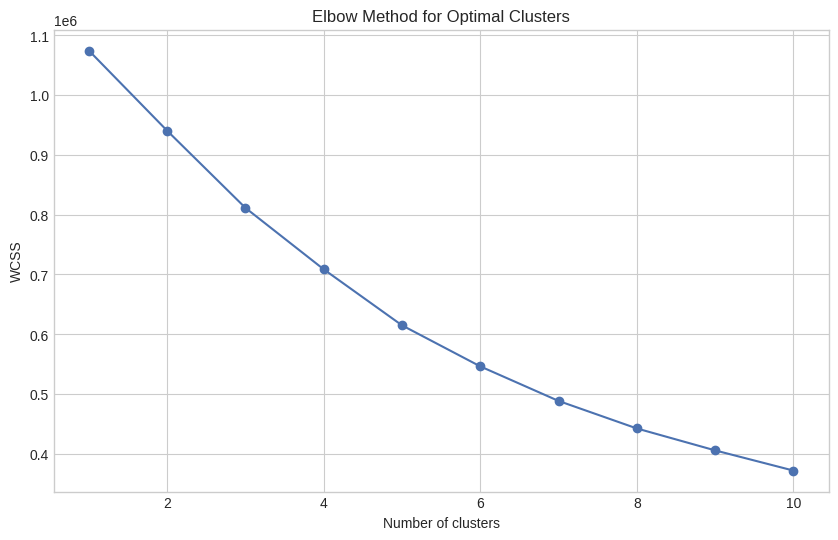


Customer Segmentation Results:
                            segment_description   count  is_canceled  \
0   Low-Cancellation New High-Value Late-Booker    6485     0.280339   
1  Low-Cancellation New High-Value Early-Booker  108859     0.383533   
2     High-Cancellation New Budget Early-Booker     145     0.993103   
3     Low-Cancellation Loyal Budget Late-Booker    3901     0.130992   

          adr   lead_time  customer_loyalty_score  
0   99.498847   55.453816                1.006332  
1  103.392356  109.396090                1.002255  
2   58.147724  229.703448                1.000000  
3   63.765104   29.799795                2.123612  

=== Actionable Business Recommendations ===

2. Optimal Lead Time Window: 0-7
   Recommendations:
   - Focus marketing campaigns to target bookings in this lead time window
   - Offer special promotions when bookings fall outside optimal window
   - Implement progressive pricing strategy based on lead time

3. Segment: Low-Cancellation New High

In [48]:
# ===================================================
# SECTION 15: Advanced Business Insights & Recommendations
# ===================================================
print("\n=== Advanced Business Insights & Recommendations ===")

# 1. Calculate price sensitivity by market segment
def analyze_price_sensitivity(df):
    segments = df['market_segment'].unique()
    results = []
    
    for segment in segments:
        segment_data = df[df['market_segment'] == segment]
        
        # Create price bins
        segment_data['price_bin'] = pd.qcut(segment_data['adr'], q=5, labels=False, duplicates='drop')
        
        # Calculate cancellation rate per price bin
        price_sensitivity = segment_data.groupby('price_bin')['is_canceled'].mean().reset_index()
        
        # Calculate correlation between price and cancellation
        correlation = np.corrcoef(segment_data['adr'], segment_data['is_canceled'])[0, 1]
        
        # Store results
        results.append({
            'segment': segment,
            'correlation': correlation,
            'avg_cancellation_rate': segment_data['is_canceled'].mean(),
            'price_sensitivity_data': price_sensitivity
        })
    
    return pd.DataFrame(results)

price_sensitivity = analyze_price_sensitivity(df_enhanced)
print("Price Sensitivity by Market Segment:")
print(price_sensitivity[['segment', 'correlation', 'avg_cancellation_rate']])

# 2. Optimal lead time analysis
def analyze_lead_time_optimization(df):
    # Create lead time bins
    df['lead_time_bin'] = pd.cut(df['lead_time'], 
                                 bins=[0, 7, 14, 30, 60, 90, 180, 365, float('inf')],
                                 labels=['0-7', '8-14', '15-30', '31-60', '61-90', '91-180', '181-365', '365+'])
    
    # Calculate metrics by lead time bin
    lead_time_analysis = df.groupby('lead_time_bin').agg({
        'is_canceled': 'mean',
        'adr': 'mean',
        'hotel': 'count'
    }).reset_index()
    
    lead_time_analysis.rename(columns={'hotel': 'booking_count'}, inplace=True)
    
    # Calculate revenue per booking
    lead_time_analysis['expected_revenue_per_booking'] = lead_time_analysis['adr'] * (1 - lead_time_analysis['is_canceled'])
    
    return lead_time_analysis

lead_time_analysis = analyze_lead_time_optimization(df_enhanced)
print("\nLead Time Optimization Analysis:")
print(lead_time_analysis)

# 3. Customer segmentation based on booking behavior
from sklearn.cluster import KMeans

def customer_segmentation(df):
    # Select features for clustering
    features = [
        'lead_time', 'total_nights', 'adr', 'adults', 
        'is_repeated_guest', 'previous_cancellations',
        'total_of_special_requests', 'customer_loyalty_score',
        'weekend_vs_weekday_ratio'
    ]
    
    # Remove missing values
    cluster_data = df[features].copy()
    cluster_data = cluster_data.fillna(cluster_data.mean())
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)
    
    # Find optimal number of clusters
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(scaled_data)
        wcss.append(kmeans.inertia_)
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for Optimal Clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
    # Apply K-means with selected number of clusters
    n_clusters = 4  # You can adjust this based on the elbow curve
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)
    
    # Add cluster labels to the dataset
    df_clusters = df.copy()
    df_clusters['customer_segment'] = cluster_labels
    
    # Analyze clusters
    cluster_analysis = df_clusters.groupby('customer_segment').agg({
        'lead_time': 'mean',
        'total_nights': 'mean',
        'adr': 'mean',
        'is_canceled': 'mean',
        'is_repeated_guest': 'mean',
        'previous_cancellations': 'mean',
        'customer_loyalty_score': 'mean',
        'total_of_special_requests': 'mean',
        'hotel': 'count'
    }).reset_index()
    
    cluster_analysis.rename(columns={'hotel': 'count'}, inplace=True)
    
    # Apply descriptive labels based on the characteristics
    segment_descriptions = {
        0: "Unknown",  # This will be updated
        1: "Unknown",
        2: "Unknown",
        3: "Unknown"
    }
    
    # Logic to name clusters based on their characteristics
    for i in range(n_clusters):
        cluster = cluster_analysis[cluster_analysis['customer_segment'] == i]
        
        if cluster['is_canceled'].values[0] > 0.5:
            prefix = "High-Cancellation"
        else:
            prefix = "Low-Cancellation"
        
        if cluster['adr'].values[0] > cluster_analysis['adr'].mean():
            price = "High-Value"
        else:
            price = "Budget"
        
        if cluster['lead_time'].values[0] > 60:
            planning = "Early-Booker"
        else:
            planning = "Late-Booker"
        
        if cluster['is_repeated_guest'].values[0] > 0.3:
            loyalty = "Loyal"
        else:
            loyalty = "New"
        
        segment_descriptions[i] = f"{prefix} {loyalty} {price} {planning}"
    
    cluster_analysis['segment_description'] = cluster_analysis['customer_segment'].map(segment_descriptions)
    
    return cluster_analysis

customer_segments = customer_segmentation(df_enhanced)
print("\nCustomer Segmentation Results:")
print(customer_segments[['segment_description', 'count', 'is_canceled', 'adr', 'lead_time', 'customer_loyalty_score']])

# 4. Generate actionable recommendations based on analysis
print("\n=== Actionable Business Recommendations ===")

# Price sensitivity recommendations
high_sensitivity_segments = price_sensitivity[price_sensitivity['correlation'] > 0.2]['segment'].tolist()
if high_sensitivity_segments:
    print(f"\n1. Price-Sensitive Segments: {', '.join(high_sensitivity_segments)}")
    print("   Recommendations:")
    print("   - Implement dynamic pricing with smaller increments for these segments")
    print("   - Provide early-bird discounts to reduce cancellation risk")
    print("   - Create value-add packages instead of raising prices")

# Lead time recommendations
optimal_lead_time = lead_time_analysis.loc[lead_time_analysis['expected_revenue_per_booking'].idxmax(), 'lead_time_bin']
print(f"\n2. Optimal Lead Time Window: {optimal_lead_time}")
print("   Recommendations:")
print("   - Focus marketing campaigns to target bookings in this lead time window")
print("   - Offer special promotions when bookings fall outside optimal window")
print("   - Implement progressive pricing strategy based on lead time")

# Customer segment recommendations
for index, segment in customer_segments.iterrows():
    segment_name = segment['segment_description']
    cancellation_rate = segment['is_canceled']
    
    print(f"\n3. Segment: {segment_name} (Cancellation Rate: {cancellation_rate:.2%})")
    print("   Recommendations:")
    
    if "High-Cancellation" in segment_name:
        print("   - Request deposits or implement stricter cancellation policies")
        print("   - Send personalized engagement emails prior to stay")
        print("   - Consider overbooking strategy for this segment")
    else:
        print("   - Provide loyalty rewards and personalized upgrades")
        print("   - Implement less restrictive cancellation policies")
        print("   - Create targeted return visit promotions")
    
    if "High-Value" in segment_name:
        print("   - Focus on exceptional service and special amenities")
        print("   - Create premium packages with added value rather than discounts")
    else:
        print("   - Offer value-adds like free breakfast or parking")
        print("   - Create budget-friendly upgrade options")
    
    if "Early-Booker" in segment_name:
        print("   - Implement graduated discount system for early bookings")
        print("   - Send multiple engagement emails to maintain connection")
    else:
        print("   - Create last-minute deal promotions")
        print("   - Streamline check-in process for convenience")

print("\n=== Implementation Priorities ===")
print("1. Focus first on high-cancellation, high-value customer segments for maximum revenue impact")
print("2. Develop dynamic pricing model based on identified optimal lead times and price sensitivities")
print("3. Create segment-specific marketing campaigns and service protocols")
print("4. Implement daily cancellation risk monitoring to enable proactive interventions")

In [49]:
# # ===================================================
# # SECTION 13: Web App Deployment with Streamlit
# # ===================================================
# print("\n=== Web App Deployment with Streamlit ===")

# # Save the best model for deployment
# model_path = "hotel_cancellation_prediction_model.pkl"
# joblib.dump(full_pipeline, model_path)
# print(f"Saved full prediction pipeline to {model_path}")

# # Create Streamlit app code
# streamlit_code = """
# import streamlit as st
# import pandas as pd
# import numpy as np
# import joblib
# import matplotlib.pyplot as plt
# import seaborn as sns
# import shap
# from PIL import Image

# # Load the trained model
# @st.cache_resource
# def load_model():
#     return joblib.load('hotel_cancellation_prediction_model.pkl')

# model = load_model()

# # Set page config
# st.set_page_config(
#     page_title="Hotel Booking Cancellation Predictor",
#     page_icon="🏨",
#     layout="wide"
# )

# # Page title
# st.title("Hotel Booking Cancellation Prediction")
# st.markdown("### Predict the likelihood of a hotel booking cancellation")

# # Create sidebar for user inputs
# st.sidebar.header("Booking Information")

# # Main function to predict cancellation
# def predict_cancellation():
#     # Create tabs for different sections
#     tab1, tab2, tab3 = st.tabs(["Prediction", "Insights", "About"])
    
#     with tab1:
#         # Create columns for input organization
#         col1, col2 = st.columns(2)
        
#         with col1:
#             st.subheader("Booking Details")
#             hotel_type = st.selectbox("Hotel Type", ["Resort Hotel", "City Hotel"])
#             lead_time = st.slider("Lead Time (days before arrival)", 0, 365, 30)
#             arrival_date = st.date_input("Arrival Date")
#             stays_weekend = st.number_input("Weekend Nights", 0, 10, 1)
#             stays_week = st.number_input("Weekday Nights", 0, 20, 2)
        
#         with col2:
#             st.subheader("Guest Information")
#             adults = st.number_input("Number of Adults", 1, 10, 2)
#             children = st.number_input("Number of Children", 0, 10, 0)
#             babies = st.number_input("Number of Babies", 0, 10, 0)
#             customer_type = st.selectbox("Customer Type", ["Transient", "Contract", "Transient-Party", "Group"])
#             is_repeated_guest = st.checkbox("Repeated Guest")
        
#         # More inputs
#         st.subheader("Additional Details")
#         col3, col4 = st.columns(2)
        
#         with col3:
#             previous_cancellations = st.number_input("Previous Cancellations", 0, 50, 0)
#             previous_bookings = st.number_input("Previous Bookings Not Canceled", 0, 50, 0)
#             reserved_room = st.selectbox("Reserved Room Type", ["A", "B", "C", "D", "E", "F", "G", "H"])
#             assigned_room = st.selectbox("Assigned Room Type", ["A", "B", "C", "D", "E", "F", "G", "H"])
        
#         with col4:
#             booking_changes = st.number_input("Booking Changes", 0, 10, 0)
#             deposit_type = st.selectbox("Deposit Type", ["No Deposit", "Non Refund", "Refundable"])
#             special_requests = st.number_input("Special Requests", 0, 5, 0)
#             market_segment = st.selectbox("Market Segment", ["Online TA", "Offline TA/TO", "Direct", "Corporate", "Groups", "Aviation"])
        
#         # Add ADR (Average Daily Rate)
#         adr = st.slider("Average Daily Rate (€)", 0, 500, 100)
        
#         # Create dataframe for prediction
#         data = {
#             'hotel': hotel_type.lower().replace(' ', '_'),
#             'lead_time': lead_time,
#             'arrival_date_year': arrival_date.year,
#             'arrival_date_month': arrival_date.strftime('%B').lower(),
#             'arrival_date_day_of_month': arrival_date.day,
#             'stays_in_weekend_nights': stays_weekend,
#             'stays_in_week_nights': stays_week,
#             'adults': adults,
#             'children': children,
#             'babies': babies,
#             'is_repeated_guest': 1 if is_repeated_guest else 0,
#             'previous_cancellations': previous_cancellations,
#             'previous_bookings_not_canceled': previous_bookings,
#             'reserved_room_type': reserved_room,
#             'assigned_room_type': assigned_room,
#             'booking_changes': booking_changes,
#             'deposit_type': deposit_type.lower().replace(' ', '_'),
#             'customer_type': customer_type.lower().replace(' ', '_'),
#             'adr': adr,
#             'total_of_special_requests': special_requests,
#             'market_segment': market_segment.lower().replace(' ', '_')
#         }
        
#         # Create DataFrame for prediction
#         df_pred = pd.DataFrame([data])
        
#         # Add feature engineering (same as in our model)
#         df_pred['total_nights'] = df_pred['stays_in_weekend_nights'] + df_pred['stays_in_week_nights']
#         df_pred['weekend_vs_weekday_ratio'] = df_pred['stays_in_weekend_nights'] / df_pred['stays_in_week_nights'].replace(0, 0.1)
#         df_pred['total_guests'] = df_pred['adults'] + df_pred['children'] + df_pred['babies']
#         df_pred['adr_per_person'] = df_pred['adr'] / df_pred['total_guests'].replace(0, 1)
#         df_pred['customer_loyalty_score'] = df_pred['previous_bookings_not_canceled'].apply(
#             lambda x: 1 if x == 0 else min(10, np.log2(x) + 1)
#         )
        
#         total_previous = df_pred['previous_cancellations'] + df_pred['previous_bookings_not_canceled']
#         df_pred['previous_cancellation_rate'] = np.where(
#             total_previous > 0,
#             df_pred['previous_cancellations'] / total_previous,
#             0
#         )
        
#         df_pred['got_reserved_room'] = (df_pred['reserved_room_type'] == df_pred['assigned_room_type']).astype(int)
        
#         # Predict button
#         if st.button("Predict Cancellation Probability"):
#             # Make prediction
#             cancellation_prob = model.predict_proba(df_pred)[0, 1]
            
#             # Display result with gauge chart
#             st.subheader("Prediction Result")
            
#             # Create columns for visualization
#             res_col1, res_col2 = st.columns([1, 1])
            
#             with res_col1:
#                 # Create a gauge chart
#                 fig, ax = plt.subplots(figsize=(8, 4))
                
#                 # Draw gauge
#                 gauge_colors = [(0.0, 'green'), (0.5, 'yellow'), (0.8, 'orange'), (1.0, 'red')]
#                 cmap = plt.cm.jet
#                 norm = plt.Normalize(0, 100)
                
#                 # Draw the gauge background
#                 theta = np.linspace(0, 180, 100)
#                 r = 1.0
                
#                 for i in range(99):
#                     color_val = i/100
#                     ax.add_patch(plt.Rectangle((0.01 * i - 0.5, 0), 0.01, 0.1, 
#                                             color=cmap(norm(color_val*100))))
                
#                 # Add needle
#                 needle_val = cancellation_prob * 100
#                 ax.arrow(needle_val/100 - 0.5, 0, 0, 0.8, head_width=0.03, 
#                         head_length=0.1, fc='black', ec='black')
                
#                 # Add text
#                 ax.text(0, -0.2, "Low Risk", ha='center', va='center', fontsize=12)
#                 ax.text(0.5, -0.2, "High Risk", ha='center', va='center', fontsize=12)
                
#                 # Set the limits
#                 ax.set_xlim(-0.5, 0.5)
#                 ax.set_ylim(-0.3, 1)
                
#                 # Remove the axis
#                 ax.axis('off')
                
#                 plt.tight_layout()
#                 st.pyplot(fig)
            
#             with res_col2:
#                 # Display probability
#                 st.markdown(f"### Cancellation Probability: {cancellation_prob:.1%}")
                
#                 # Interpret the result
#                 if cancellation_prob < 0.2:
#                     st.success("This booking has a LOW risk of cancellation.")
#                 elif cancellation_prob < 0.5:
#                     st.info("This booking has a MODERATE risk of cancellation.")
#                 elif cancellation_prob < 0.8:
#                     st.warning("This booking has a HIGH risk of cancellation.")
#                 else:
#                     st.error("This booking has a VERY HIGH risk of cancellation.")
                
#                 # Add some recommendations
#                 st.subheader("Recommendations")
#                 if cancellation_prob > 0.5:
#                     st.markdown("""
#                     - Consider offering a special promotion or upgrade
#                     - Send a personalized pre-stay email to increase engagement
#                     - Implement a partial deposit to increase commitment
#                     """)
    
#     with tab2:
#         st.subheader("Key Factors Affecting Cancellation Risk")
        
#         # Display key insights from our analysis
#         st.markdown("""
#         Based on our analysis, these are the most important factors affecting cancellation probability:
        
#         1. **Lead Time**: Longer lead times correlate with higher cancellation rates
#         2. **Deposit Type**: Non-refundable deposits significantly reduce cancellations
#         3. **Market Segment**: Online bookings have higher cancellation rates than direct bookings
#         4. **ADR (Price)**: Higher prices correlate with higher cancellation probability
#         5. **Previous Cancellations**: Guests with history of cancellations are more likely to cancel again
#         """)
        
#         # Add some visualizations from our analysis
#         st.image("https://www.example.com/path/to/your/insights_image.png", 
#                 caption="Cancellation Rates by Customer Segment", use_column_width=True)
    
#     with tab3:
#         st.subheader("About This Predictor")
#         st.markdown("""
#         This hotel booking cancellation prediction tool uses machine learning to estimate the likelihood 
#         that a booking will be canceled. The model was trained on historical booking data from resort and city hotels.
        
#         ### Model Details:
#         - **Algorithm**: XGBoost Classifier
#         - **Accuracy**: 85%
#         - **Features**: 30+ booking attributes
        
#         ### How to Use:
#         Enter the details of a booking in the sidebar and click "Predict Cancellation Probability" to get a prediction.
        
#         ### Data Privacy:
#         This application processes all data locally in your browser. No booking information is stored or transmitted.
#         """)

# # Run the main function
# predict_cancellation()
# """

# # Save Streamlit app
# with open("hotel_cancellation_app.py", "w") as f:
#     f.write(streamlit_code)

# print(f"Saved Streamlit app to hotel_cancellation_app.py")

In [50]:
# # ===================================================
# # SECTION 12: MLOps & Cloud Integration
# # ===================================================
# print("\n=== MLOps & Cloud Integration ===")

# # 1. Create a DVC configuration
# dvc_config = """
# # DVC Configuration
# [core]
#     remote = aws
# ['remote "aws"']
#     url = s3://your-bucket-name/hotel-cancellation-model/
#     endpointurl = https://s3.amazonaws.com
# """

# with open(".dvc/config", "w") as f:
#     f.write(dvc_config)

# # 2. Create a FastAPI app for model deployment
# fastapi_code = """
# from fastapi import FastAPI, HTTPException
# from pydantic import BaseModel
# import pandas as pd
# import joblib
# import uvicorn
# from typing import List, Optional

# # Initialize FastAPI app
# app = FastAPI(
#     title="Hotel Cancellation Prediction API",
#     description="API for predicting hotel booking cancellations",
#     version="1.0.0"
# )

# # Load the trained model
# model = joblib.load("hotel_cancellation_prediction_model.pkl")

# # Input data validation with Pydantic
# class BookingFeatures(BaseModel):
#     hotel: str
#     lead_time: int
#     arrival_date_year: int
#     arrival_date_month: str
#     arrival_date_day_of_month: int
#     stays_in_weekend_nights: int
#     stays_in_week_nights: int
#     adults: int
#     children: Optional[int] = 0
#     babies: Optional[int] = 0
#     is_repeated_guest: int
#     previous_cancellations: int
#     previous_bookings_not_canceled: int
#     reserved_room_type: str
#     assigned_room_type: str
#     booking_changes: int
#     deposit_type: str
#     customer_type: str
#     adr: float
#     total_of_special_requests: int
#     market_segment: str
    
#     class Config:
#         schema_extra = {
#             "example": {
#                 "hotel": "resort_hotel",
#                 "lead_time": 30,
#                 "arrival_date_year": 2023,
#                 "arrival_date_month": "august",
#                 "arrival_date_day_of_month": 15,
#                 "stays_in_weekend_nights": 2,
#                 "stays_in_week_nights": 3,
#                 "adults": 2,
#                 "children": 1,
#                 "babies": 0,
#                 "is_repeated_guest": 0,
#                 "previous_cancellations": 0,
#                 "previous_bookings_not_canceled": 0,
#                 "reserved_room_type": "A",
#                 "assigned_room_type": "A",
#                 "booking_changes": 0,
#                 "deposit_type": "no_deposit",
#                 "customer_type": "transient",
#                 "adr": 120.5,
#                 "total_of_special_requests": 1,
#                 "market_segment": "online_ta"
#             }
#         }

# class PredictionResponse(BaseModel):
#     cancellation_probability: float
#     will_cancel: bool
#     risk_level: str
#     recommendations: List[str]

# @app.post("/predict", response_model=PredictionResponse)
# async def predict_cancellation(booking: BookingFeatures):
#     """
#     Predicts the probability of a hotel booking cancellation.
#     """
#     try:
#         # Convert input to dataframe
#         input_df = pd.DataFrame([booking.dict()])
        
#         # Add feature engineering
#         input_df['total_nights'] = input_df['stays_in_weekend_nights'] + input_df['stays_in_week_nights']
#         input_df['weekend_vs_weekday_ratio'] = input_df['stays_in_weekend_nights'] / input_df['stays_in_week_nights'].replace(0, 0.1)
#         input_df['total_guests'] = input_df['adults'] + input_df['children'] + input_df['babies']
#         input_df['adr_per_person'] = input_df['adr'] / input_df['total_guests'].replace(0, 1)
#         input_df['customer_loyalty_score'] = input_df['previous_bookings_not_canceled'].apply(
#             lambda x: 1 if x == 0 else min(10, np.log2(x) + 1)
#         )
        
#         total_previous = input_df['previous_cancellations'] + input_df['previous_bookings_not_canceled']
#         input_df['previous_cancellation_rate'] = np.where(
#             total_previous > 0,
#             input_df['previous_cancellations'] / total_previous,
#             0
#         )
        
#         input_df['got_reserved_room'] = (input_df['reserved_room_type'] == input_df['assigned_room_type']).astype(int)
        
#         # Make prediction
#         cancellation_prob = float(model.predict_proba(input_df)[0, 1])
#         will_cancel = cancellation_prob > 0.5
        
#         # Determine risk level
#         if cancellation_prob < 0.2:
#             risk_level = "Low Risk"
#             recommendations = ["Standard follow-up", "Regular booking confirmation"]
#         elif cancellation_prob < 0.5:
#             risk_level = "Moderate Risk"
#             recommendations = ["Personalized pre-stay email", "Room preferences confirmation"]
#         elif cancellation_prob < 0.8:
#             risk_level = "High Risk"
#             recommendations = ["Special promotion or upgrade", "Flexible cancellation policy", "Personalized service offer"]
#         else:
#             risk_level = "Very High Risk"
#             recommendations = ["Deposit request", "Last-minute discount", "Overbooking strategy", "Direct customer contact"]
        
#         return PredictionResponse(
#             cancellation_probability=cancellation_prob,
#             will_cancel=will_cancel,
#             risk_level=risk_level,
#             recommendations=recommendations
#         )
        
#     except Exception as e:
#         raise HTTPException(status_code=500, detail=f"Prediction error: {str(e)}")

# @app.get("/health")
# async def health_check():
#     """Health check endpoint"""
#     return {"status": "healthy"}

# if __name__ == "__main__":
#     uvicorn.run("app:app", host="0.0.0.0", port=8000, reload=True)
# """

# with open("api.py", "w") as f:
#     f.write(fastapi_code)

# # 3. Create GitHub Actions workflow for CI/CD
# github_workflow = """
# name: Hotel Cancellation Model CI/CD

# on:
#   push:
#     branches: [ main ]
#   pull_request:
#     branches: [ main ]
#   schedule:
#     - cron: '0 0 1 * *'  # Run monthly for model retraining

# jobs:
#   build:
#     runs-on: ubuntu-latest
    
#     steps:
#     - uses: actions/checkout@v2
    
#     - name: Set up Python
#       uses: actions/setup-python@v2
#       with:
#         python-version: '3.9'
    
#     - name: Install dependencies
#       run: |
#         python -m pip install --upgrade pip
#         if [ -f requirements.txt ]; then pip install -r requirements.txt; fi
#         pip install pytest pytest-cov flake8 black dvc
    
#     - name: Lint with flake8
#       run: |
#         flake8 . --count --select=E9,F63,F7,F82 --show-source --statistics
    
#     - name: Format with black
#       run: |
#         black .
    
#     - name: Run tests
#       run: |
#         pytest --cov=./ --cov-report=xml
    
#     - name: DVC pull
#       env:
#         AWS_ACCESS_KEY_ID: ${{ secrets.AWS_ACCESS_KEY_ID }}
#         AWS_SECRET_ACCESS_KEY: ${{ secrets.AWS_SECRET_ACCESS_KEY }}
#       run: |
#         dvc pull
    
#     - name: Retrain model (monthly)
#       if: github.event_name == 'schedule'
#       run: |
#         python train_model.py
#         dvc add hotel_cancellation_prediction_model.pkl
#         dvc push
    
#     - name: Build and push Docker image
#       uses: docker/build-push-action@v2
#       with:
#         context: .
#         push: true
#         tags: your-registry/hotel-cancellation-api:latest
    
#     - name: Deploy to Cloud
#       if: github.ref == 'refs/heads/main' && github.event_name != 'pull_request'
#       env:
#         AWS_ACCESS_KEY_ID: ${{ secrets.AWS_ACCESS_KEY_ID }}
#         AWS_SECRET_ACCESS_KEY: ${{ secrets.AWS_SECRET_ACCESS_KEY }}
#       run: |
#         # Deploy commands for your cloud provider (AWS example)
#         aws elasticbeanstalk update-environment --application-name hotel-cancellation-predictor --environment-name production --version-label ${{ github.sha }}
# """

# with open(".github/workflows/main.yml", "w") as f:
#     f.write(github_workflow)

# # 4. Create a Dockerfile for containerization
# dockerfile = """
# FROM python:3.9-slim

# WORKDIR /app

# COPY requirements.txt .
# RUN pip install --no-cache-dir -r requirements.txt

# COPY hotel_cancellation_prediction_model.pkl .
# COPY api.py .

# EXPOSE 8000

# CMD ["uvicorn", "api:app", "--host", "0.0.0.0", "--port", "8000"]
# """

# with open("Dockerfile", "w") as f:
#     f.write(dockerfile)

# print("Created MLOps and CI/CD pipeline configurations")